In [374]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plts
from datetime import datetime


In [5]:
reference_data_new = pd.read_csv("data/raw_aact/combined_neuro_trials_with_interventions_20240313.csv")

In [6]:
reference_data_new[reference_data_new['intervention_name'].str.contains('Lecanemab', case=False, na=False, regex=True)].drop_duplicates()


,nct_id,Neurological Disease,Disease Class,brief_title,study_official_title,brief_summary_description,start_date,completion_date,phase,study_type,overall_status,country_name,intervention_name,intervention_type
120716,NCT05269394,Dementia,Diseases of the nervous system|Central Nervous...,Dominantly Inherited Alzheimer Network Trial: ...,"A Phase II/III Multicenter Randomized, Double-...","To assess the safety, tolerability, biomarker,...",2021-12-22,2027-10-31,Phase 2/Phase 3,Interventional,Recruiting,United States,Lecanemab,Drug
120719,NCT05269394,Dementia,Diseases of the nervous system|Central Nervous...,Dominantly Inherited Alzheimer Network Trial: ...,"A Phase II/III Multicenter Randomized, Double-...","To assess the safety, tolerability, biomarker,...",2021-12-22,2027-10-31,Phase 2/Phase 3,Interventional,Recruiting,Argentina,Lecanemab,Drug
120722,NCT05269394,Dementia,Diseases of the nervous system|Central Nervous...,Dominantly Inherited Alzheimer Network Trial: ...,"A Phase II/III Multicenter Randomized, Double-...","To assess the safety, tolerability, biomarker,...",2021-12-22,2027-10-31,Phase 2/Phase 3,Interventional,Recruiting,Australia,Lecanemab,Drug
120725,NCT05269394,Dementia,Diseases of the nervous system|Central Nervous...,Dominantly Inherited Alzheimer Network Trial: ...,"A Phase II/III Multicenter Randomized, Double-...","To assess the safety, tolerability, biomarker,...",2021-12-22,2027-10-31,Phase 2/Phase 3,Interventional,Recruiting,Brazil,Lecanemab,Drug
120728,NCT05269394,Dementia,Diseases of the nervous system|Central Nervous...,Dominantly Inherited Alzheimer Network Trial: ...,"A Phase II/III Multicenter Randomized, Double-...","To assess the safety, tolerability, biomarker,...",2021-12-22,2027-10-31,Phase 2/Phase 3,Interventional,Recruiting,Canada,Lecanemab,Drug
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373847,NCT01760005,Dementia,Diseases of the nervous system|Central Nervous...,Dominantly Inherited Alzheimer Network Trial: ...,"A Phase II/III Multicenter Randomized, Double-...",The purpose of this study is to assess the saf...,2012-12-31,2027-10-31,Phase 2/Phase 3,Interventional,Recruiting,Netherlands,Lecanemab,Drug
373855,NCT01760005,Dementia,Diseases of the nervous system|Central Nervous...,Dominantly Inherited Alzheimer Network Trial: ...,"A Phase II/III Multicenter Randomized, Double-...",The purpose of this study is to assess the saf...,2012-12-31,2027-10-31,Phase 2/Phase 3,Interventional,Recruiting,Puerto Rico,Lecanemab,Drug
373863,NCT01760005,Dementia,Diseases of the nervous system|Central Nervous...,Dominantly Inherited Alzheimer Network Trial: ...,"A Phase II/III Multicenter Randomized, Double-...",The purpose of this study is to assess the saf...,2012-12-31,2027-10-31,Phase 2/Phase 3,Interventional,Recruiting,Spain,Lecanemab,Drug
373871,NCT01760005,Dementia,Diseases of the nervous system|Central Nervous...,Dominantly Inherited Alzheimer Network Trial: ...,"A Phase II/III Multicenter Randomized, Double-...",The purpose of this study is to assess the saf...,2012-12-31,2027-10-31,Phase 2/Phase 3,Interventional,Recruiting,United Kingdom,Lecanemab,Drug


In [7]:
reference_data_new[reference_data_new['intervention_name'].str.contains('Leqembi', case=False, na=False, regex=True)].drop_duplicates()


,nct_id,Neurological Disease,Disease Class,brief_title,study_official_title,brief_summary_description,start_date,completion_date,phase,study_type,overall_status,country_name,intervention_name,intervention_type


# Load annotated data

In [8]:
data_path = Path("data/annotated_aact/")


In [9]:
df_annotations_all = pd.read_csv(data_path/ "ner_outputs/aggregated_ner_annotations_basic_dict_mapped_19632.csv")
df_annotations_all.shape

(19632, 8)

In [10]:
df_annotations_all.head(2)

,Unnamed: 0,nct_id,canonical_BioLinkBERT-base_interventions,canonical_aact_interventions,aact_intervention_types,canonical_BioLinkBERT-base_conditions,canonical_aact_conditions,Disease Class
0,0,NCT00000117,intravenous immunoglobulin|ivig,immunoglobulin,Drug,multiple sclerosis|optic neuritis,optic neuritis,Cranial Nerve Diseases
1,1,NCT00000146,corticosteroid,prednisone|methylprednisolone,Drug,multiple sclerosis|optic neuritis,optic neuritis|multiple sclerosis,Demyelinating Diseases|Cranial Nerve Diseases


In [11]:
model_prefix = "combined_union"
entity_types = ["conditions", "interventions"]
if model_prefix == "linkbert":
    mapped_size = [18212, 16917]
elif model_prefix == "aact":
    mapped_size = [19632, 18720]
else:
    mapped_size = [19632, 19632]

In [12]:
# Loop through each entity type, read the corresponding file, and perform the join
for entity_type, mapped_nr in zip(entity_types, mapped_size):
    # Construct the file path
    file_path = data_path / f"snomed_linking_outputs/mapped_to_hierarchy/aact_bert_combined/hierarchical_mapping_to_snomed_{model_prefix}_{entity_type}_aggregated_{mapped_nr}.csv"
    
    # Read the data
    df_entity = pd.read_csv(file_path, index_col=0)
    
    # Perform the left join on nct_id
    df_annotations_all = df_annotations_all.merge(df_entity, on='nct_id', how='left')

if model_prefix == "combined":
    df_annotations_all[f'canonical_combined_{entity_type}'] = df_annotations_all[f'canonical_BioLinkBERT-base_{entity_type}'].combine_first(df_annotations_all[f'canonical_aact_{entity_type}'])


In [13]:
df_annotations_all.shape

(19632, 20)

In [14]:
df_annotations_all.head(2)

,Unnamed: 0,nct_id,canonical_BioLinkBERT-base_interventions,canonical_aact_interventions,aact_intervention_types,canonical_BioLinkBERT-base_conditions,canonical_aact_conditions,Disease Class,linkbert_snomed_term_canonical_conditions,linkbert_top_concept_canonical_first_conditions,aact_snomed_term_canonical_conditions,aact_top_concept_canonical_first_conditions,combined_union_snomed_term_canonical_conditions,combined_union_top_concept_canonical_first_conditions,linkbert_snomed_term_canonical_interventions,linkbert_top_concept_canonical_first_interventions,aact_snomed_term_canonical_interventions,aact_top_concept_canonical_first_interventions,combined_union_snomed_term_canonical_interventions,combined_union_top_concept_canonical_first_interventions
0,0,NCT00000117,intravenous immunoglobulin|ivig,immunoglobulin,Drug,multiple sclerosis|optic neuritis,optic neuritis,Cranial Nerve Diseases,Multiple sclerosis (disorder)|Optic neuritis (...,Multiple sclerosis (disorder)|Optic neuritis (...,Optic neuritis (disorder),Optic neuritis (disorder),Multiple sclerosis (disorder)|Optic neuritis (...,Multiple sclerosis (disorder)|Optic neuritis (...,Immunoglobulin (substance),Immunoglobulin (substance),Immunoglobulin (substance),Blood component (substance),Immunoglobulin (substance),Blood component (substance)|Immunoglobulin (su...
1,1,NCT00000146,corticosteroid,prednisone|methylprednisolone,Drug,multiple sclerosis|optic neuritis,optic neuritis|multiple sclerosis,Demyelinating Diseases|Cranial Nerve Diseases,Multiple sclerosis (disorder)|Optic neuritis (...,Multiple sclerosis (disorder)|Optic neuritis (...,Optic neuritis (disorder)|Multiple sclerosis (...,Optic neuritis (disorder)|Multiple sclerosis (...,Multiple sclerosis (disorder)|Optic neuritis (...,Multiple sclerosis (disorder)|Optic neuritis (...,Corticosteroid and/or corticosteroid derivativ...,Corticosteroid and/or corticosteroid derivativ...,Prednisone (substance)|Methylprednisolone (sub...,Corticosteroid and/or corticosteroid derivativ...,Corticosteroid and/or corticosteroid derivativ...,Corticosteroid and/or corticosteroid derivativ...


### Prepare for analysis
NOTE: The reference that in this version contains only the neuro trials, which contained an intervention annotation from BioLinkBERT (DRUG) or AACT

#### decide which columns to plot

In [15]:
evaluate_snomed_link = True
hierarchical_mapping_conditions = True
hierarchical_mapping_interventions = False

if  model_prefix == "linkbert":
    target_ner_column_prefix = 'canonical_BioLinkBERT-base'
elif model_prefix == "aact":
    target_ner_column_prefix = 'canonical_aact'
else:
    target_ner_column_prefix = 'canonical_combined'

if evaluate_snomed_link:
    if hierarchical_mapping_conditions and hierarchical_mapping_interventions:
        target_interventions_column = f'{model_prefix}_top_concept_canonical_first_interventions'
        target_conditions_column = f'{model_prefix}_top_concept_canonical_first_conditions'
        annotations_type = f'{model_prefix}_sapbert_hierarchical'
    elif hierarchical_mapping_conditions and (not hierarchical_mapping_interventions):
        target_interventions_column = f'{model_prefix}_snomed_term_canonical_interventions'
        target_conditions_column = f'{model_prefix}_top_concept_canonical_first_conditions'
        annotations_type = f'{model_prefix}_sapbert_cond_hier'
    elif hierarchical_mapping_interventions and (not hierarchical_mapping_conditions):
        target_interventions_column = f'{model_prefix}_top_concept_canonical_first_interventions'
        target_conditions_column = f'{model_prefix}_snomed_term_canonical_conditions'
        annotations_type = f'{model_prefix}_sapbert_interv_hier'
    else:
        target_interventions_column = f'{model_prefix}_snomed_term_canonical_interventions'
        target_conditions_column = f'{model_prefix}_snomed_term_canonical_conditions'
        annotations_type = f'{model_prefix}_sapbert'
else:
    target_interventions_column = f'{target_ner_column_prefix}_interventions'
    target_conditions_column = f'{target_ner_column_prefix}_conditions'
    annotations_type = model_prefix


In [16]:
annotations_type

'combined_union_sapbert_cond_hier'

#### select columns to plot and merge with metadata

In [17]:
df_normalized_annotations = df_annotations_all[['nct_id', target_interventions_column, target_conditions_column]]
reference_data_with_target_annotations = df_normalized_annotations.merge(reference_data_new, on='nct_id', how='left')
reference_data_with_target_annotations.head(2)

,nct_id,combined_union_snomed_term_canonical_interventions,combined_union_top_concept_canonical_first_conditions,Neurological Disease,Disease Class,brief_title,study_official_title,brief_summary_description,start_date,completion_date,phase,study_type,overall_status,country_name,intervention_name,intervention_type
0,NCT00000117,Immunoglobulin (substance),Multiple sclerosis (disorder)|Optic neuritis (...,Optic Neuritis,Cranial Nerve Diseases,Intravenous Immunoglobulin Therapy in Optic Ne...,NaN,To determine whether high-dose intravenous imm...,1995-08-31,1997-12-31,Phase 3,Interventional,Completed,United States,Immunoglobulin,Drug
1,NCT00000117,Immunoglobulin (substance),Multiple sclerosis (disorder)|Optic neuritis (...,Optic Neuritis,Cranial Nerve Diseases,Intravenous Immunoglobulin Therapy in Optic Ne...,NaN,To determine whether high-dose intravenous imm...,1995-08-31,1997-12-31,Phase 3,Interventional,Completed,United States,Immunoglobulin,Drug


In [18]:
reference_data_with_target_annotations_to_save = reference_data_with_target_annotations[['nct_id','brief_title', 'Neurological Disease', 'Disease Class', 'brief_summary_description']]

In [19]:
reference_data_with_target_annotations_to_save.head()

,nct_id,brief_title,Neurological Disease,Disease Class,brief_summary_description
0,NCT00000117,Intravenous Immunoglobulin Therapy in Optic Ne...,Optic Neuritis,Cranial Nerve Diseases,To determine whether high-dose intravenous imm...
1,NCT00000117,Intravenous Immunoglobulin Therapy in Optic Ne...,Optic Neuritis,Cranial Nerve Diseases,To determine whether high-dose intravenous imm...
2,NCT00000117,Intravenous Immunoglobulin Therapy in Optic Ne...,Optic Neuritis,Cranial Nerve Diseases,To determine whether high-dose intravenous imm...
3,NCT00000146,Optic Neuritis Treatment Trial (ONTT),Multiple Sclerosis,Demyelinating Diseases,To assess the beneficial and adverse effects o...
4,NCT00000146,Optic Neuritis Treatment Trial (ONTT),Multiple Sclerosis,Demyelinating Diseases,To assess the beneficial and adverse effects o...


In [20]:
len(set(reference_data_with_target_annotations['nct_id'])), reference_data_with_target_annotations.shape

(19632, (262638, 16))

In [21]:
reference_data_with_target_annotations.head(2)

,nct_id,combined_union_snomed_term_canonical_interventions,combined_union_top_concept_canonical_first_conditions,Neurological Disease,Disease Class,brief_title,study_official_title,brief_summary_description,start_date,completion_date,phase,study_type,overall_status,country_name,intervention_name,intervention_type
0,NCT00000117,Immunoglobulin (substance),Multiple sclerosis (disorder)|Optic neuritis (...,Optic Neuritis,Cranial Nerve Diseases,Intravenous Immunoglobulin Therapy in Optic Ne...,NaN,To determine whether high-dose intravenous imm...,1995-08-31,1997-12-31,Phase 3,Interventional,Completed,United States,Immunoglobulin,Drug
1,NCT00000117,Immunoglobulin (substance),Multiple sclerosis (disorder)|Optic neuritis (...,Optic Neuritis,Cranial Nerve Diseases,Intravenous Immunoglobulin Therapy in Optic Ne...,NaN,To determine whether high-dose intravenous imm...,1995-08-31,1997-12-31,Phase 3,Interventional,Completed,United States,Immunoglobulin,Drug


#### explode to have single entity per row

In [22]:
drug_col_name = 'Drug Intervention'
condition_col_name = 'Neurological Condition'

In [23]:
# replace the raw aact column with normalized columns
reference_data_with_target_annotations = reference_data_with_target_annotations.drop(columns=['Neurological Disease', 'intervention_name'])

reference_data_with_target_annotations[target_interventions_column] = reference_data_with_target_annotations[target_interventions_column].str.split('|')
reference_data_with_target_annotations[target_conditions_column] = reference_data_with_target_annotations[target_conditions_column].str.split('|')

# Exploding both columns to create new rows for each value
df_exploded_target_annotations = reference_data_with_target_annotations.explode(target_interventions_column)
df_exploded_target_annotations = df_exploded_target_annotations.explode(target_conditions_column)

# rename the target model columns to a standard column name
df_exploded_target_annotations.rename(columns={target_interventions_column: drug_col_name}, inplace=True)
df_exploded_target_annotations.rename(columns={target_conditions_column: condition_col_name}, inplace=True)

reference_data = df_exploded_target_annotations.copy()
# Convert 'start_date' and 'completion_date' to datetime
reference_data['start_date'] = pd.to_datetime(reference_data['start_date'])
reference_data['completion_date'] = pd.to_datetime(reference_data['completion_date'])

# Extract the year from 'start_date' and 'completion_date'
reference_data['start_year'] = reference_data['start_date'].dt.year
reference_data['completion_year'] = reference_data['completion_date'].dt.year

reference_data = reference_data[reference_data['start_year']<2024]
reference_data = reference_data[reference_data['start_year']>=2000]


In [24]:
len(set(reference_data['nct_id']))

18609

In [25]:
# Function to format long intervention names with new line after every 4 words
def format_long_name(name, max_words=4):
    if isinstance(name, float):
        return ''  # Handle NaN values
    words = name.split()
    if len(words) > max_words:
        return '\n'.join([' '.join(words[i:i+max_words]) for i in range(0, len(words), max_words)])
    return name

# Apply the formatting function to the dataframe
reference_data[drug_col_name] = reference_data[drug_col_name].apply(format_long_name)
reference_data[condition_col_name] = reference_data[condition_col_name].apply(format_long_name)


In [26]:
reference_data_with_entity_tags = reference_data.copy()

In [27]:
len(set(reference_data_with_entity_tags['nct_id']))

18609

#### remove snomed (type)

In [28]:
# Function to remove (substance) and (disorder) suffixes
def remove_suffixes(text):
    if isinstance(text, str):
        text = text.replace('(substance)', '').replace('(disorder)', '').strip()
    return text

# Apply the function to the relevant columns
reference_data[drug_col_name] = reference_data[drug_col_name].apply(remove_suffixes)
reference_data[condition_col_name] = reference_data[condition_col_name].apply(remove_suffixes)


In [29]:
reference_data.shape

(2135022, 16)

In [30]:
reference_data.head(2)

,nct_id,Drug Intervention,Neurological Condition,Disease Class,brief_title,study_official_title,brief_summary_description,start_date,completion_date,phase,study_type,overall_status,country_name,intervention_type,start_year,completion_year
382,NCT00000307,Naltrexone,Disorder caused by alcohol,Diseases Category,Naltrexone as Adjunct in Alcoholic Cocaine Dep...,Naltrexone as an Adjunct in Alcoholic Cocaine ...,The purpose of this study is to evaluate naltr...,2003-04-30,2007-04-30,Phase 2,Interventional,Completed,United States,Drug,2003.0,2007.0
382,NCT00000307,Naltrexone,Disorder caused by cocaine,Diseases Category,Naltrexone as Adjunct in Alcoholic Cocaine Dep...,Naltrexone as an Adjunct in Alcoholic Cocaine ...,The purpose of this study is to evaluate naltr...,2003-04-30,2007-04-30,Phase 2,Interventional,Completed,United States,Drug,2003.0,2007.0


In [31]:
len(set(df_normalized_annotations['nct_id'])), df_normalized_annotations.shape

(19632, (19632, 3))

In [32]:
len(set(reference_data['nct_id']))

18609

# Diseases

In [33]:
viz_path_diseases = Path("viz/conditions/")

In [34]:
reference_data.head(5)

,nct_id,Drug Intervention,Neurological Condition,Disease Class,brief_title,study_official_title,brief_summary_description,start_date,completion_date,phase,study_type,overall_status,country_name,intervention_type,start_year,completion_year
382,NCT00000307,Naltrexone,Disorder caused by alcohol,Diseases Category,Naltrexone as Adjunct in Alcoholic Cocaine Dep...,Naltrexone as an Adjunct in Alcoholic Cocaine ...,The purpose of this study is to evaluate naltr...,2003-04-30,2007-04-30,Phase 2,Interventional,Completed,United States,Drug,2003.0,2007.0
382,NCT00000307,Naltrexone,Disorder caused by cocaine,Diseases Category,Naltrexone as Adjunct in Alcoholic Cocaine Dep...,Naltrexone as an Adjunct in Alcoholic Cocaine ...,The purpose of this study is to evaluate naltr...,2003-04-30,2007-04-30,Phase 2,Interventional,Completed,United States,Drug,2003.0,2007.0
383,NCT00000307,Naltrexone,Disorder caused by alcohol,Diseases Category,Naltrexone as Adjunct in Alcoholic Cocaine Dep...,Naltrexone as an Adjunct in Alcoholic Cocaine ...,The purpose of this study is to evaluate naltr...,2003-04-30,2007-04-30,Phase 2,Interventional,Completed,United States,Drug,2003.0,2007.0
383,NCT00000307,Naltrexone,Disorder caused by cocaine,Diseases Category,Naltrexone as Adjunct in Alcoholic Cocaine Dep...,Naltrexone as an Adjunct in Alcoholic Cocaine ...,The purpose of this study is to evaluate naltr...,2003-04-30,2007-04-30,Phase 2,Interventional,Completed,United States,Drug,2003.0,2007.0
384,NCT00000307,Naltrexone,Disorder caused by alcohol,Diseases Category,Naltrexone as Adjunct in Alcoholic Cocaine Dep...,Naltrexone as an Adjunct in Alcoholic Cocaine ...,The purpose of this study is to evaluate naltr...,2003-04-30,2007-04-30,Phase 2,Interventional,Completed,United States,Drug,2003.0,2007.0


In [35]:
reference_data.columns

Index(['nct_id', 'Drug Intervention', 'Neurological Condition',
       'Disease Class', 'brief_title', 'study_official_title',
       'brief_summary_description', 'start_date', 'completion_date', 'phase',
       'study_type', 'overall_status', 'country_name', 'intervention_type',
       'start_year', 'completion_year'],
      dtype='object')

In [36]:
aact_diseases = reference_data[['nct_id', condition_col_name, 'Disease Class', 'phase', 'overall_status','start_year','completion_year']]

In [37]:
def plot_entity_frequency(data, entity_column, entity_type, annotations_type, viz_path, top_n=20):
    """
    Generates a horizontal bar chart for the frequency of entities (e.g., diseases, interventions) 
    and saves it to a specified path.

    Parameters:
    data (pd.DataFrame): The input dataframe containing 'nct_id' and the specified entity column.
    entity_column (str): The column name in the dataframe representing the entities (e.g., diseases, interventions).
    annotations_type (str): A string to specify the type of annotations for the title and filename.
    viz_path (Path or str): The path where the plot image will be saved.
    top_n (int): The number of top items to display in the chart. Default is 20.
    """

    # Keeping only unique nct_id, entity pairs
    unique_pairs = data[['nct_id', entity_column]].drop_duplicates()

    # Counting the number of nct_ids per entity type
    entity_counts = unique_pairs[entity_column].value_counts()
    entity_counts = entity_counts.sort_values(ascending=True).tail(top_n)

    # Create a horizontal bar chart for the top N data types
    plt.figure(figsize=(10, 8))
    bars = plt.barh(entity_counts.index, entity_counts, color='lightgrey', zorder=2, height=0.7)  #)

    # Add labels to each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width}', va='center', fontsize=12)

    plt.tick_params(axis='y', labelsize=14)
    plt.tick_params(axis='x', labelsize=15)
    plt.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
    plt.xlabel('Number of unique trials', fontsize=15)
    plt.title(f'Top {top_n} {entity_column}', fontsize=15)
    plt.xlim(0, max(entity_counts) + max(entity_counts)/10)  # Adjusted to max count for relevancy
    plt.tight_layout()

    # Save the plot to the specified path
    plot_filename = viz_path / f'{entity_type}_frequency_{annotations_type}.png'
    plt.savefig(plot_filename)

    # Display the chart
    plt.show()


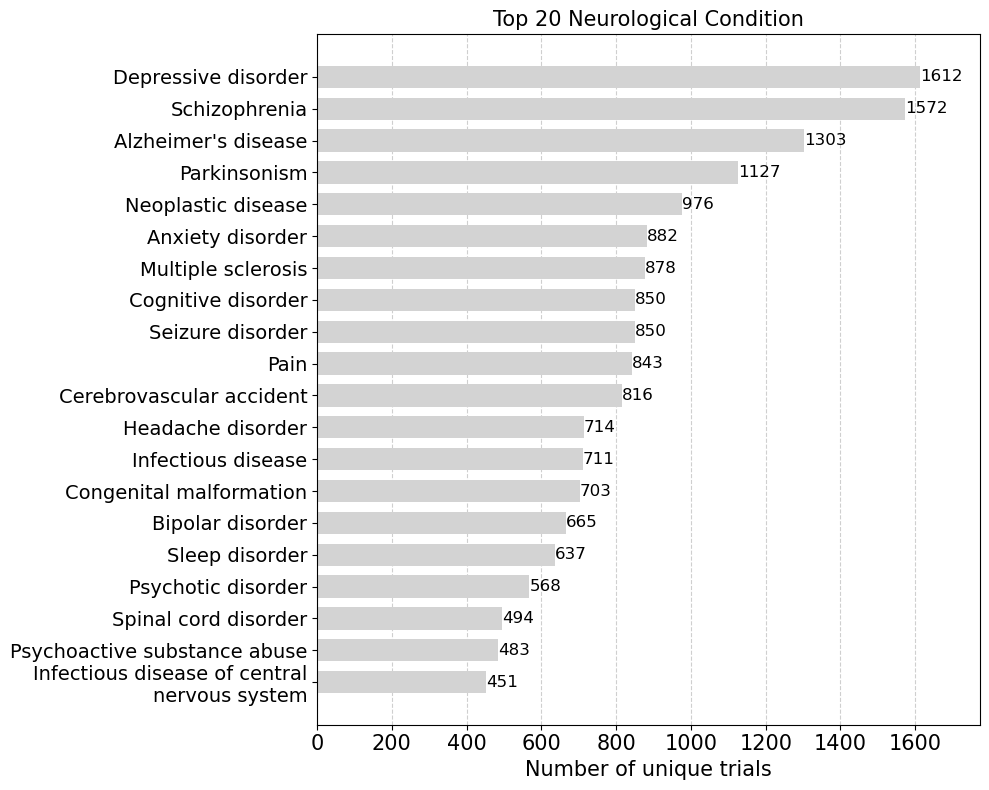

In [38]:
plot_entity_frequency(aact_diseases, condition_col_name, 'disease', annotations_type, viz_path_diseases, top_n=20)


## Disease/ All and Completed Trials

In [39]:
aact_diseases[['nct_id', condition_col_name]].drop_duplicates()

,nct_id,Neurological Condition
382,NCT00000307,Disorder caused by alcohol
382,NCT00000307,Disorder caused by cocaine
438,NCT00000333,Cocaine
438,NCT00000333,Disorder caused by cocaine
588,NCT00000428,Fibromyalgia
...,...,...
262587,NCT06292351,Dementia
262602,NCT06293586,Acute disease of cardiovascular\nsystem
262602,NCT06293586,Congenital malformation
262602,NCT06293586,Perioperative complication


In [40]:
# Step 1: Count total trials per disease
total_disease_counts = aact_diseases[['nct_id', condition_col_name]].drop_duplicates()[condition_col_name].value_counts()

# Filter 'Completed' status and count completed trials per disease
completed_trials = aact_diseases[aact_diseases['overall_status'] == 'Completed']
completed_disease_counts = completed_trials[['nct_id', condition_col_name]].drop_duplicates()[condition_col_name].value_counts()

# Calculate proportions of completed trials
completed_proportions = (completed_disease_counts / total_disease_counts).fillna(0) * 100  # Proportion in percentage

# Sorting to get top 20 diseases by total count
sorted_diseases = total_disease_counts.sort_values(ascending=True).tail(20)
sorted_completed_proportions = completed_proportions.reindex(index=sorted_diseases.index)
sorted_completed_proportions

Neurological Condition
Infectious disease of central\nnervous system    77.827051
Psychoactive substance abuse                     76.604555
Spinal cord disorder                             53.846154
Psychotic disorder                               72.007042
Sleep disorder                                   62.951334
Bipolar disorder                                 70.075188
Congenital malformation                          49.928876
Infectious disease                               59.634318
Headache disorder                                64.145658
Cerebrovascular accident                         51.348039
Pain                                             56.109134
Seizure disorder                                 65.294118
Cognitive disorder                               58.705882
Multiple sclerosis                               58.428246
Anxiety disorder                                 56.349206
Neoplastic disease                               51.741803
Parkinsonism                     

In [41]:
total_disease_counts[:50]

Neurological Condition
Depressive disorder                                                                     1612
Schizophrenia                                                                           1572
Alzheimer's disease                                                                     1303
Parkinsonism                                                                            1127
Neoplastic disease                                                                       976
Anxiety disorder                                                                         882
Multiple sclerosis                                                                       878
Seizure disorder                                                                         850
Cognitive disorder                                                                       850
Pain                                                                                     843
Cerebrovascular accident                       

In [42]:
top_50 = total_disease_counts.index[:50]

In [43]:
top_50

Index(['Depressive disorder', 'Schizophrenia', 'Alzheimer's disease',
       'Parkinsonism', 'Neoplastic disease', 'Anxiety disorder',
       'Multiple sclerosis', 'Seizure disorder', 'Cognitive disorder', 'Pain',
       'Cerebrovascular accident', 'Headache disorder', 'Infectious disease',
       'Congenital malformation', 'Bipolar disorder', 'Sleep disorder',
       'Psychotic disorder', 'Spinal cord disorder',
       'Psychoactive substance abuse',
       'Infectious disease of central\nnervous system', 'Sexual disorder',
       'Neoplasm of nervous system', 'Developmental mental disorder',
       'Motor neuron disease', 'Peripheral nerve disease',
       'Traumatic brain injury', 'Confusional state',
       'Schizoaffective disorder', 'Cranial neuralgia',
       'Bodily distress disorder', 'Analgesia', 'Perioperative complication',
       'Hereditary metabolic disease', 'Dementia',
       'Neurological pain disorder', 'Substance dependence',
       'Pervasive developmental disorder

In [44]:
def plot_entity_trials(data, entity_column, entity_type, status_column, status_value, annotations_type, viz_path, top_n=20):
    """
    Generates a horizontal bar chart for the total and completed trials per entity (e.g., diseases, interventions) 
    and saves it to a specified path.

    Parameters:
    data (pd.DataFrame): The input dataframe containing 'nct_id', the specified entity column, and the status column.
    entity_column (str): The column name in the dataframe representing the entities (e.g., diseases, interventions).
    status_column (str): The column name representing the status of the trials.
    status_value (str): The value in the status column representing the completed status.
    annotations_type (str): A string to specify the type of annotations for the title and filename.
    viz_path (Path or str): The path where the plot image will be saved.
    top_n (int): The number of top items to display in the chart. Default is 20.
    """
    # Ensure viz_path is a Path object
    viz_path = Path(viz_path)

    # Step 1: Count total trials per entity, ensuring unique nct_id within each entity
    total_entity_counts = data[['nct_id', entity_column]].drop_duplicates()[entity_column].value_counts()

    # Step 2: Filter completed status and count completed trials per entity, ensuring unique nct_id
    completed_trials = data[data[status_column] == status_value]
    completed_entity_counts = completed_trials[['nct_id', entity_column]].drop_duplicates()[entity_column].value_counts()

    # Sorting total_entity_counts in descending order to determine plot order and select top entities
    sorted_entities = total_entity_counts.sort_values(ascending=True).tail(top_n+1).index

    # Reindexing completed_entity_counts according to sorted_entities for alignment
    completed_entity_counts = completed_entity_counts.reindex(index=sorted_entities).fillna(0)

    # Step 3: Plot a horizontal bar chart
    plt.figure(figsize=(10, 7))

    # Plotting total trials
    bars_total = plt.barh(sorted_entities, total_entity_counts[sorted_entities], color='lightgrey', label='Total Trials')

    # Plotting completed trials
    bars_completed = plt.barh(sorted_entities, completed_entity_counts[sorted_entities], color='darkgrey', label='Completed Trials')

    #plt.ylabel(entity_column.capitalize(), fontsize=15)
    plt.xlabel('Number of unique trials', fontsize=15)
    plt.title(f'Top {top_n} {entity_column} with Completed Trials Count', fontsize=16)
    plt.yticks(ticks=range(len(sorted_entities)), labels=sorted_entities)
    plt.legend()

    # Adding labels to the bars
    for bar in bars_total:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{int(bar.get_width())}', va='center', ha='left')

    for bar in bars_completed:
        width = bar.get_width()
        # Only label the bar if the width is significant to avoid clutter
        if width > 0:
            plt.text(width, bar.get_y() + bar.get_height() / 2, f'{int(width)}', va='center', ha='right', color='white')

    plt.xlim(0, max(total_entity_counts) + 100)  # Adjusted to max count for relevancy
    plt.tight_layout()
    plt.savefig(viz_path / f'{entity_type}_frequency_with_completed_{annotations_type}.png')

    plt.show()

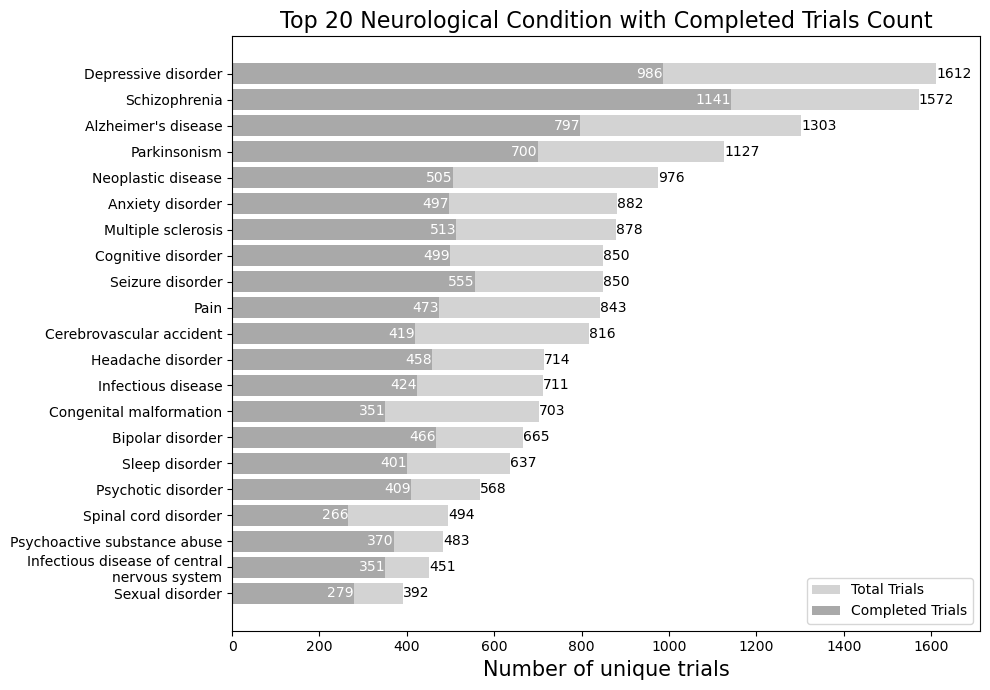

In [45]:
plot_entity_trials(aact_diseases, condition_col_name, 'disease', 'overall_status', 'Completed', annotations_type, viz_path_diseases, top_n=20)


## Disease/ Phase

In [46]:
# Aggregate trials by disease and phase, counting unique nct_ids
disease_phase_counts = aact_diseases.groupby([condition_col_name, 'phase'])['nct_id'].nunique().reset_index()

# Pivot the data to have diseases as rows and phases as columns, filling missing values with 0
pivot_df = disease_phase_counts.pivot(index=condition_col_name, columns='phase', values='nct_id').fillna(0)

# Calculate total trials per disease to identify the top 20 diseases
pivot_df['Total Trials'] = pivot_df.sum(axis=1)
top_20_diseases = pivot_df.sort_values('Total Trials', ascending=False).head(21)
top_20_diseases

phase,Early Phase 1,Not Applicable,Phase 1,Phase 1/Phase 2,Phase 2,Phase 2/Phase 3,Phase 3,Phase 4,Total Trials
Neurological Condition,,,,,,,,,
Depressive disorder,46.0,380.0,125.0,45.0,311.0,53.0,238.0,414.0,1612.0
Schizophrenia,18.0,205.0,247.0,40.0,283.0,41.0,339.0,399.0,1572.0
Alzheimer's disease,42.0,125.0,337.0,66.0,391.0,35.0,195.0,112.0,1303.0
Parkinsonism,23.0,122.0,224.0,66.0,335.0,38.0,169.0,150.0,1127.0
Neoplastic disease,44.0,193.0,140.0,73.0,280.0,27.0,120.0,99.0,976.0
Anxiety disorder,28.0,202.0,47.0,26.0,243.0,42.0,110.0,184.0,882.0
Multiple sclerosis,14.0,84.0,118.0,60.0,210.0,31.0,200.0,161.0,878.0
Seizure disorder,9.0,118.0,109.0,24.0,159.0,26.0,243.0,162.0,850.0
Cognitive disorder,15.0,120.0,114.0,30.0,325.0,38.0,95.0,113.0,850.0


In [47]:
def plot_phase_distribution(data, entity_column, entity_type, phase_column, nct_id_column, annotations_type, viz_path, top_n=20):
    """
    Generates a horizontal bar chart for the phase distribution within top entities (e.g., diseases) 
    and saves it to a specified path.

    Parameters:
    data (pd.DataFrame): The input dataframe containing entity, phase, and nct_id columns.
    entity_column (str): The column name in the dataframe representing the entities (e.g., diseases).
    phase_column (str): The column name representing the phases of the trials.
    nct_id_column (str): The column name representing the unique trial IDs.
    annotations_type (str): A string to specify the type of annotations for the title and filename.
    viz_path (Path or str): The path where the plot image will be saved.
    top_n (int): The number of top entities to display in the chart. Default is 20.
    """
    # Step 1: Count total trials per entity per phase
    entity_phase_counts = data.groupby([entity_column, phase_column])[nct_id_column].nunique().reset_index()
    
    # Step 2: Pivot the filtered data to have entities as rows and phases as columns, filling missing values with 0
    pivot_df_filtered = entity_phase_counts.pivot(index=entity_column, columns=phase_column, values=nct_id_column).fillna(0)
    
    # Step 3: Calculate total trials per entity to identify the top N entities
    pivot_df_filtered['Total Trials'] = pivot_df_filtered.sum(axis=1)
    top_entities_filtered = pivot_df_filtered.sort_values('Total Trials', ascending=False).head(top_n)
    
    # Step 4: Drop the 'Total Trials' column as it's no longer needed for plotting
    top_entities_filtered = top_entities_filtered.drop(columns='Total Trials')
    
    # Step 5: Normalize phase counts to proportions within each entity
    normalized_phases_filtered = top_entities_filtered.div(top_entities_filtered.sum(axis=1), axis=0) * 100
    
    # Step 6: Reverse the row order of normalized_phases to have the largest on top
    normalized_phases_filtered_reversed = normalized_phases_filtered.iloc[::-1]
    
    # Convert the DataFrame to a numpy array for easier iteration in plotting
    data_array = normalized_phases_filtered_reversed.to_numpy()
    
    # The y-axis positions for each entity
    y_positions = np.arange(len(normalized_phases_filtered_reversed))
    
    # Setting up the plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Colors for each phase, assuming a limited number of phases
    colors = plt.cm.viridis(np.linspace(0, 1, normalized_phases_filtered_reversed.shape[1]))
    
    # Cumulative array to keep track of where to start the next bar segment
    cumulative = np.zeros(len(normalized_phases_filtered_reversed))
    
    for i, (phase_name, color) in enumerate(zip(normalized_phases_filtered_reversed.columns, colors)):
        # The height of the bar for this phase
        phase_data = data_array[:, i]
        
        # Plotting the bar segment
        if phase_name == 'Not Applicable':
            ax.barh(y_positions, phase_data, color='grey', left=cumulative, edgecolor='none', label=phase_name)
        else:
            ax.barh(y_positions, phase_data, color=color, left=cumulative, edgecolor='none', label=phase_name)
        
        # Updating the cumulative sum for the next bar segment
        cumulative += phase_data
        
        # Adding text labels within each bar segment
        for y, (x_position, width) in enumerate(zip(cumulative, phase_data)):
            if width > 0:  # Only add labels for visible segments
                label_color = 'black' if phase_name in ['Phase 3', 'Phase 4'] else 'white'
                label = f'{width:.0f}%'
                ax.text(x_position - width / 2, y, label, va='center', ha='center', color=label_color, fontsize=8)
    
    # Setting the y-ticks to correspond to entities
    ax.set_yticks(y_positions)
    ax.set_yticklabels(normalized_phases_filtered_reversed.index)
    plt.tick_params(axis='y', labelsize=13)
    plt.tick_params(axis='x', labelsize=13)
    
    plt.xlabel('Proportion (%)', fontsize=15)
    plt.title(f'Phase Distribution within Top {top_n} {entity_column} (Normalized to 100%)', fontsize=16)
    plt.legend(title='Phase', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(viz_path / f'{entity_type}_phase_proportions_{annotations_type}.png')
    
    plt.show()

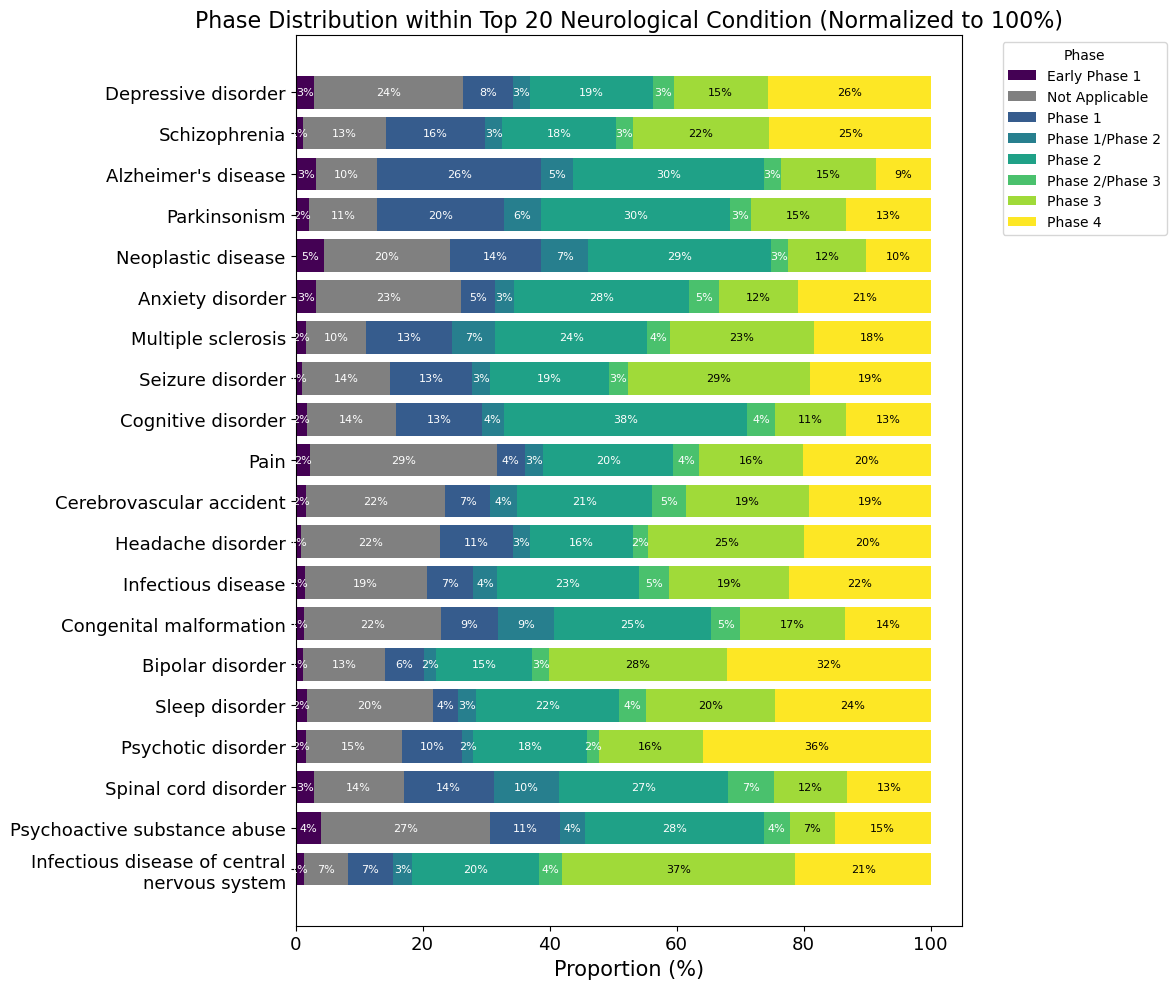

In [48]:
plot_phase_distribution(aact_diseases, condition_col_name, "disease", 'phase', 'nct_id', annotations_type, viz_path_diseases, top_n=20)


## Disease/ Time

In [49]:
def plot_distribution_over_time(data, entity_column, entity_type, year_column, nct_id_column, annotations_type, viz_path, top_n=10, save_to='pdf'):
    """
    Generates a line chart showing the distribution of top entities (e.g., diseases) over start years 
    and saves it to a specified path.

    Parameters:
    data (pd.DataFrame): The input dataframe containing entity, start year, and nct_id columns.
    entity_column (str): The column name in the dataframe representing the entities (e.g., diseases).
    year_column (str): The column name representing the start year of the trials.
    nct_id_column (str): The column name representing the unique trial IDs.
    annotations_type (str): A string to specify the type of annotations for the title and filename.
    viz_path (Path or str): The path where the plot image will be saved.
    top_n (int): The number of top entities to display in the chart. Default is 10.
    """
    # Step 1: Keeping only unique nct_id, entity pairs
    unique_pairs = data[[nct_id_column, entity_column]].drop_duplicates()
    
    # Step 2: Counting the number of nct_ids per entity type and selecting the top N
    entity_counts = unique_pairs[entity_column].value_counts().sort_values(ascending=False).head(top_n)
    
    # Step 3: Filter data to include only the top N entities
    data_top_entities = data[data[entity_column].isin(entity_counts.index)]
    data_top_entities = data_top_entities[[nct_id_column, entity_column, year_column]].drop_duplicates()
    
    # Step 4: Group by start year and entity, count occurrences, and unstack to pivot entities as columns
    grouped = data_top_entities.groupby([year_column, entity_column]).size().unstack(fill_value=0)

    print(entity_counts)
    
    # Step 5: Plot the line chart
    ax = grouped.plot(kind='line', marker='o', figsize=(12, 8))
    
    # Set the title and labels
    plt.title(f'Unique trials for Top {top_n} {entity_column} over Start Year',fontsize=15)
    plt.xlabel('Start Year', fontsize=15)
    #plt.ylabel('Trials Count', fontsize=15)

        # Sorting the legend handles
    handles, labels = ax.get_legend_handles_labels()
    sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: entity_counts[x[1]], reverse=True)
    sorted_handles, sorted_labels = zip(*sorted_handles_labels)
    plt.legend(sorted_handles, sorted_labels, fontsize=15, loc='upper left')
    

    # Adjusting the tick size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Show the plot
    #plt.legend(fontsize=15, loc='upper left')
    plt.grid(linestyle='--', alpha=0.6, zorder=1)
    plt.tight_layout()
    
    plt.savefig(viz_path / f"{entity_type}_over_time_{annotations_type}_top_{top_n}.{save_to}")
    plt.show()

In [50]:
def plot_stacked_over_time(data, entity_column, entity_type, year_column, nct_id_column, annotations_type, viz_path, top_n=10, save_to='pdf', custom_palette=None):
    """
    Generates a stacked bar chart showing the distribution of top entities (e.g., diseases) over start years 
    and saves it to a specified path.

    Parameters:
    data (pd.DataFrame): The input dataframe containing entity, start year, and nct_id columns.
    entity_column (str): The column name in the dataframe representing the entities (e.g., diseases).
    year_column (str): The column name representing the start year of the trials.
    nct_id_column (str): The column name representing the unique trial IDs.
    annotations_type (str): A string to specify the type of annotations for the title and filename.
    viz_path (Path or str): The path where the plot image will be saved.
    top_n (int): The number of top entities to display in the chart. Default is 10.
    custom_palette (list): A list of colors to use for the bars. Default is None.
    save_to (str): The file format to save the plot. Default is 'pdf'.
    """
    # Step 1: Keeping only unique nct_id, entity pairs
    unique_pairs = data[[nct_id_column, entity_column]].drop_duplicates()
    
    # Step 2: Counting the number of nct_ids per entity type and selecting the top N
    entity_counts = unique_pairs[entity_column].value_counts().sort_values(ascending=False).head(top_n)
    
    # Step 3: Filter data to include only the top N entities
    data_top_entities = data[data[entity_column].isin(entity_counts.index)]
    data_top_entities = data_top_entities[[nct_id_column, entity_column, year_column]].drop_duplicates()
    
    # Step 4: Group by start year and entity, count occurrences, and unstack to pivot entities as columns
    grouped = data_top_entities.groupby([year_column, entity_column]).size().unstack(fill_value=0)
    
    # Step 5: Normalize the counts to get proportions
    grouped_proportions = grouped.div(grouped.sum(axis=1), axis=0)
    
    # Step 6: Sort the columns based on the total count of each disease
    grouped_proportions = grouped_proportions[entity_counts.index]

    # Step 7: Plot the stacked bar chart
    ax = grouped_proportions.plot(kind='bar', stacked=True, figsize=(10, 8), color=custom_palette, zorder=2)

    # Set the title and labels
    plt.title(f'Proportion of Trials for Top {top_n} {entity_column} over Start Year', fontsize=15)
    plt.xlabel('Start Year', fontsize=15)
    #plt.ylabel('Proportion of Trials', fontsize=15)

    # Add labels to each segment
    for bars in ax.containers:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.0%}', ha='center', va='center', fontsize=10, rotation=90)

    # Sorting the legend handles and bars
    handles, labels = ax.get_legend_handles_labels()
    sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: entity_counts[x[1]])
    sorted_handles, sorted_labels = zip(*sorted_handles_labels)  # Reverse the order
    plt.legend(sorted_handles, sorted_labels, fontsize=12, loc='upper left', bbox_to_anchor=(1.00, 1))

    # Adjusting the tick size and labels
    plt.xticks(ticks=range(0, len(grouped_proportions.index), 5), labels=[int(year) for year in grouped_proportions.index[::5]], fontsize=15, rotation=0)
    plt.yticks(fontsize=14)

    # Set y-axis limits and labels
    ax.set_ylim(0, 1)
    ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])

    # Show the plot
    plt.grid(linestyle='--', alpha=0.6, zorder=1)
    plt.tight_layout()
    
    plt.savefig(viz_path / f"{entity_type}_over_time_{annotations_type}_top_{top_n}_stacked.{save_to}")
    plt.show()

In [51]:
def plot_stacked_over_time_global_totals(data, entity_column, entity_type, year_column, nct_id_column, annotations_type, viz_path, top_n=10, save_to='pdf', custom_palette=None):
    """
    Generates a stacked bar chart showing the distribution of top entities (e.g., diseases) over start years 
    and saves it to a specified path.

    Parameters:
    data (pd.DataFrame): The input dataframe containing entity, start year, and nct_id columns.
    entity_column (str): The column name in the dataframe representing the entities (e.g., diseases).
    year_column (str): The column name representing the start year of the trials.
    nct_id_column (str): The column name representing the unique trial IDs.
    annotations_type (str): A string to specify the type of annotations for the title and filename.
    viz_path (Path or str): The path where the plot image will be saved.
    top_n (int): The number of top entities to display in the chart. Default is 10.
    custom_palette (list): A list of colors to use for the bars. Default is None.
    save_to (str): The file format to save the plot. Default is 'pdf'.
    """
    # Step 1: Keeping only unique nct_id, entity pairs
    unique_pairs = data[[nct_id_column, entity_column]].drop_duplicates()
    
    # Step 2: Counting the number of nct_ids per entity type and selecting the top N
    entity_counts = unique_pairs[entity_column].value_counts().sort_values(ascending=False).head(top_n)
    
    # Step 3: Filter data to include only the top N entities
    data_top_entities = data[data[entity_column].isin(entity_counts.index)]
    data_top_entities = data_top_entities[[nct_id_column, entity_column, year_column]].drop_duplicates()
    
    # Step 4: Group by start year and entity, count occurrences, and unstack to pivot entities as columns
    grouped = data_top_entities.groupby([year_column, entity_column]).size().unstack(fill_value=0)
    
    # Step 5: Normalize the counts to get proportions
    yearly_totals = data.groupby(year_column)[nct_id_column].nunique()
    print("yearly totals")
    print(yearly_totals)
    grouped_proportions = grouped.div(yearly_totals, axis=0)
    
    # Step 6: Sort the columns based on the total count of each disease
    grouped_proportions = grouped_proportions[entity_counts.index]

    # Step 7: Plot the stacked bar chart
    ax = grouped_proportions.plot(kind='bar', stacked=True, figsize=(11, 8), color=custom_palette, zorder=2)

    # Set the title and labels
    plt.title(f'Proportion of Trials for Top {top_n} {entity_column} over Start Year', fontsize=15)
    plt.xlabel('Start Year', fontsize=15)
    #plt.ylabel('Proportion of Trials', fontsize=15)

    # Add labels to each segment
    for bars in ax.containers:
        for bar in bars:
            height = bar.get_height()
            if height > 0.03:
                bar_color = bar.get_facecolor()
                # Convert the color to hex format and check if it matches '#332288'
                hex_color = '#{:02x}{:02x}{:02x}'.format(int(bar_color[0]*255), int(bar_color[1]*255), int(bar_color[2]*255))
                label_color = 'white' if ((hex_color.lower() == '#332288') or (hex_color.lower() == '#882255')) else 'black'
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.0%}', ha='center', va='center', fontsize=10, rotation=90, color=label_color)
                #ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.0%}', ha='center', va='center', fontsize=10, rotation=90, color='white')

    # Sorting the legend handles and bars
    handles, labels = ax.get_legend_handles_labels()
    sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: entity_counts[x[1]], reverse=False)
    sorted_handles, sorted_labels = zip(*sorted_handles_labels)
    plt.legend(sorted_handles, sorted_labels, fontsize=14, loc='upper left', bbox_to_anchor=(1.00, 1))

    # Adjusting the tick size and labels
    plt.xticks(ticks=range(0, len(grouped_proportions.index), 5), labels=[int(year) for year in grouped_proportions.index[::5]], fontsize=15, rotation=0)
    plt.yticks(fontsize=14)

    # Set y-axis limits and labels
    ax.set_ylim(0, 1)
    ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])

    # Show the plot
    plt.grid(linestyle='--', alpha=0.6, zorder=1)
    plt.tight_layout()
    
    plt.savefig(viz_path / f"{entity_type}_over_time_{annotations_type}_top_{top_n}_stacked_totals.{save_to}")
    plt.show()

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_68234/1530534109.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])


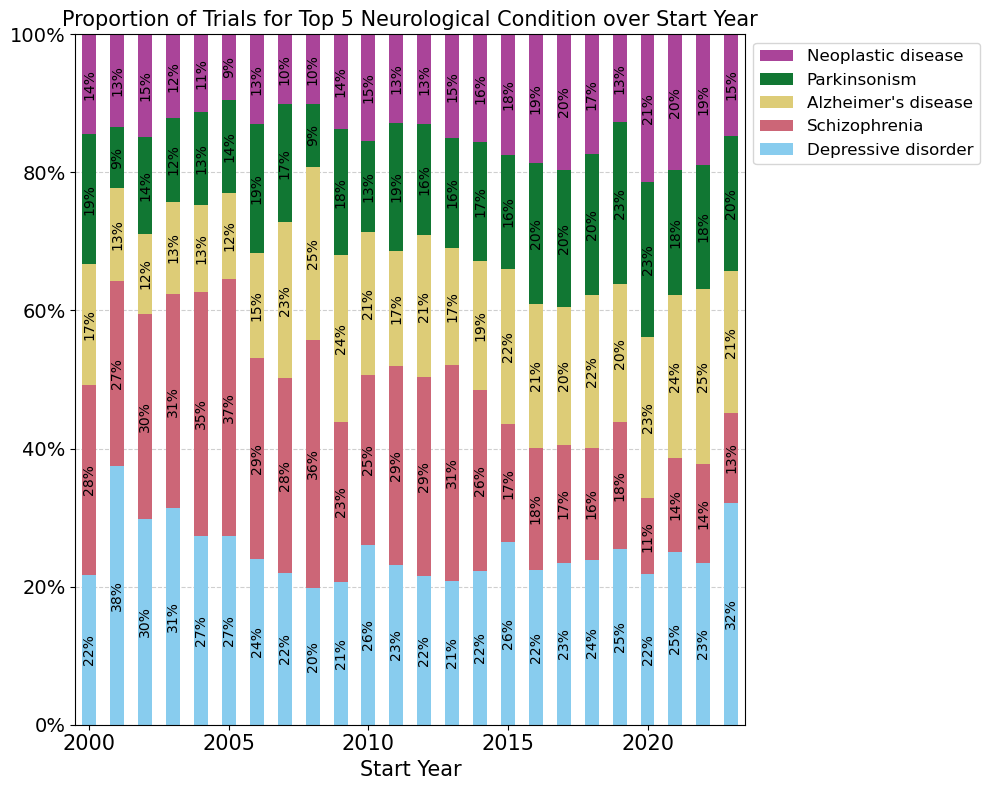

In [52]:
custom_colors = ['#88CCEE', '#CC6677', '#DDCC77', '#117733', '#AA4499', '#44AA99', '#332288', '#882255', '#E69F00', '#D55E00']

plot_stacked_over_time(aact_diseases, condition_col_name, 'disease', 'start_year', 'nct_id', annotations_type, viz_path_diseases, top_n=5, custom_palette = custom_colors)


yearly totals
start_year
2000.0     136
2001.0     235
2002.0     315
2003.0     515
2004.0     660
2005.0     728
2006.0     822
2007.0     813
2008.0     869
2009.0     904
2010.0     865
2011.0     824
2012.0     807
2013.0     773
2014.0     877
2015.0     904
2016.0     862
2017.0     902
2018.0     902
2019.0     964
2020.0     901
2021.0    1078
2022.0    1005
2023.0     948
Name: nct_id, dtype: int64


/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_68234/1695848084.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])


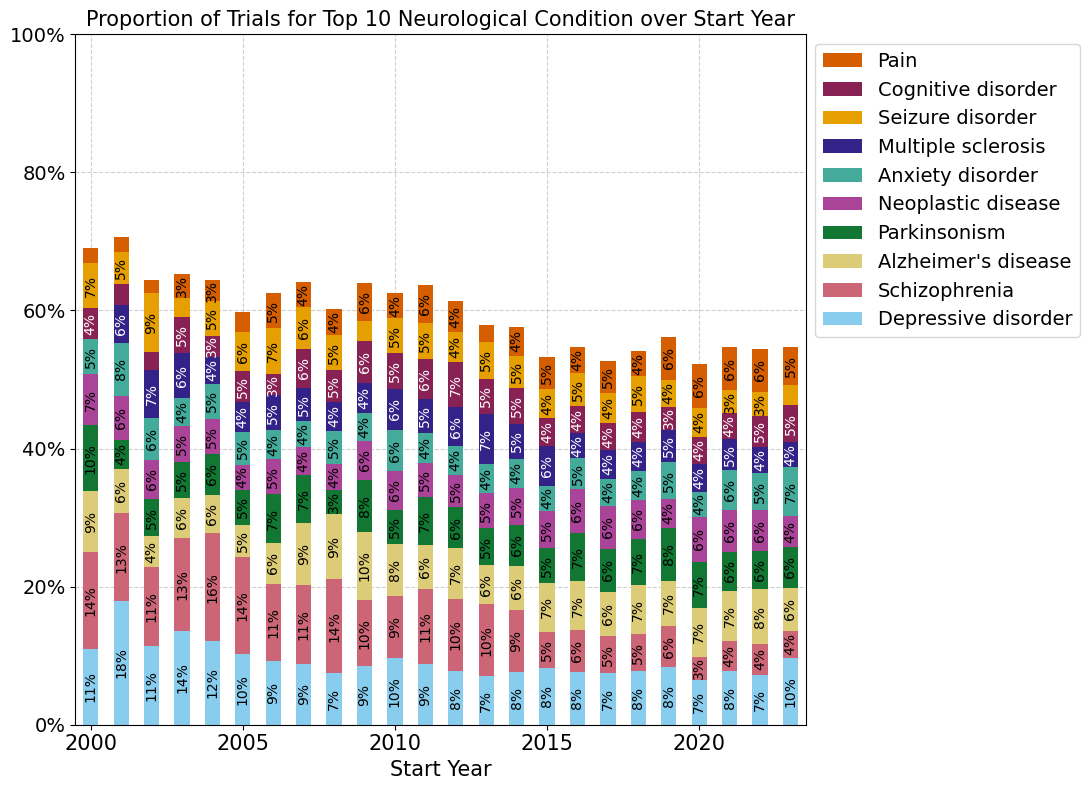

In [53]:
plot_stacked_over_time_global_totals(aact_diseases, condition_col_name, 'disease', 'start_year', 'nct_id', annotations_type, viz_path_diseases, top_n=10, custom_palette = custom_colors)


Neurological Condition
Depressive disorder    1612
Schizophrenia          1572
Alzheimer's disease    1303
Parkinsonism           1127
Neoplastic disease      976
Name: count, dtype: int64


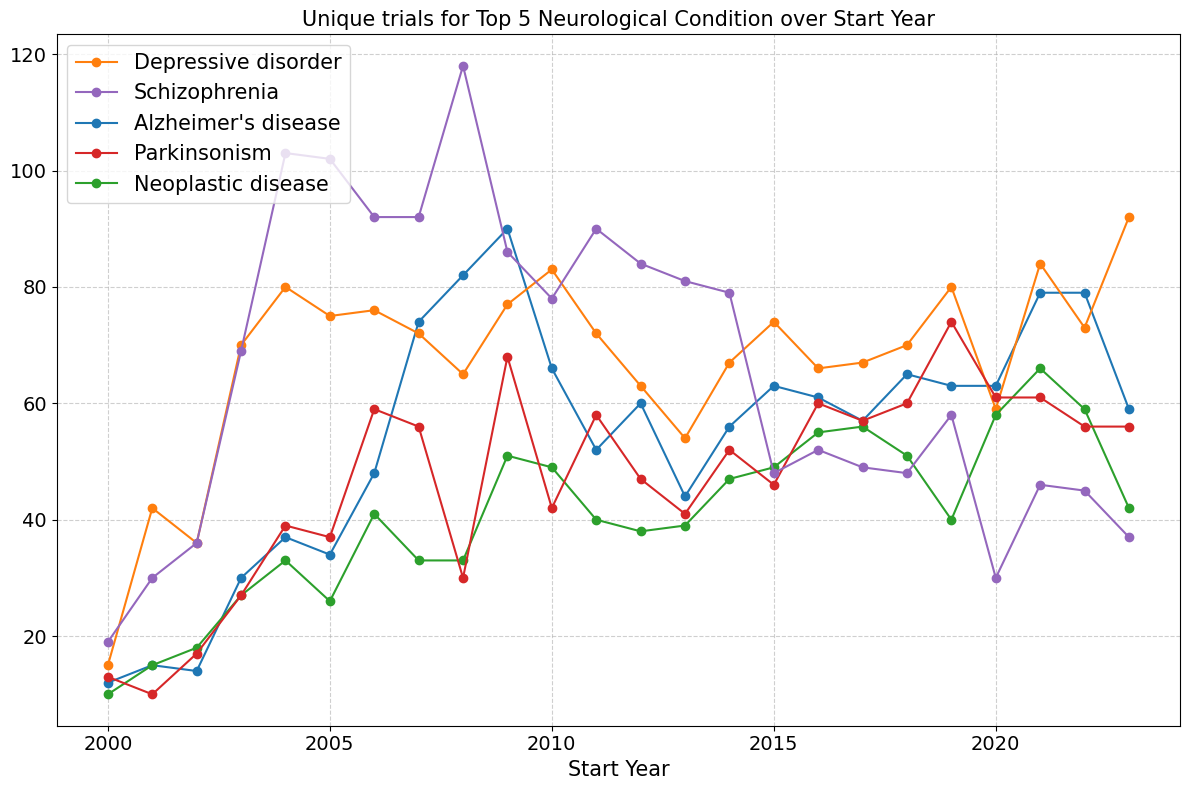

In [54]:
plot_distribution_over_time(aact_diseases, condition_col_name, 'disease', 'start_year', 'nct_id', annotations_type, viz_path_diseases, top_n=5)


## Trends

In [139]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


### S-Curve or Logistic Function


In [187]:
df_unique_trials = aact_diseases[['nct_id', 'Neurological Condition','start_year']].drop_duplicates()

print(df_unique_trials.shape)
unique_trials_per_year = df_unique_trials.groupby(['Neurological Condition', 'start_year']).size().reset_index(name='unique_trials_count')
unique_trials_per_year = unique_trials_per_year.sort_values(by='unique_trials_count', ascending=True)
print(unique_trials_per_year.shape)

# Step 1: Identify conditions with only one trial count
condition_counts = df_unique_trials['Neurological Condition'].value_counts()
single_entry_conditions = condition_counts[condition_counts <= 5].index
multiple_entry_conditions = condition_counts[condition_counts > 5].index

single_entry_df = unique_trials_per_year[unique_trials_per_year['Neurological Condition'].isin(single_entry_conditions)]
multiple_entry_df = unique_trials_per_year[unique_trials_per_year['Neurological Condition'].isin(multiple_entry_conditions)]

print(single_entry_df.shape, multiple_entry_df.shape)

test_norm = multiple_entry_df.copy()
# Step 2: Apply normalization to the filtered data with multiple entries
test_norm['Normalized Trials'] = test_norm.groupby('Neurological Condition')['unique_trials_count'].transform(
    lambda x: 0 if x.max() == x.min() else (x - x.min()) / (x.max() - x.min())
)
test_norm.head(10)

(48130, 3)
(11180, 3)
(3251, 3) (7929, 3)


,Neurological Condition,start_year,unique_trials_count,Normalized Trials
6104,Kidney disease,2010.0,1,0.0
6103,Kidney disease,2008.0,1,0.0
6102,Kidney disease,2002.0,1,0.0
6101,Kidney disease,2001.0,1,0.0
6098,Ketosis,2021.0,1,0.0
6095,Ketosis,2016.0,1,0.0
6094,Ketosis,2014.0,1,0.0
6093,Ketosis,2013.0,1,0.0
6092,Ketosis,2010.0,1,0.0
6106,Kidney disease,2016.0,1,0.0


In [120]:
len(set(test_norm['Neurological Condition']))

528

In [305]:
test_norm[test_norm['Neurological Condition']=="Pd"]

,Neurological Condition,start_year,unique_trials_count,Normalized Trials
8338,Pd,2010.0,1,0.000000
8333,Pd,2005.0,1,0.000000
8332,Pd,2003.0,2,0.111111
8336,Pd,2008.0,3,0.222222
8351,Pd,2023.0,4,0.333333
8341,Pd,2013.0,5,0.444444
8345,Pd,2017.0,5,0.444444
8343,Pd,2015.0,6,0.555556
8349,Pd,2021.0,6,0.555556
8350,Pd,2022.0,6,0.555556


In [89]:
nan_rows = test_norm[test_norm.isna().any(axis=1)]
nan_rows

,Neurological Condition,start_year,unique_trials_count,Normalized Trials


In [306]:
# Define the logistic function
def logistic_function(t, L, t0, k):
    y = L / (1 + np.exp(-k * (t - t0))) #+ b
    return y

def fit_and_evaluate(df, min_trials=5, use_normalized_trials_count = False):
    # Count the number of trials per condition
    condition_counts = df['Neurological Condition'].value_counts()
    print('Nr of conditions ', len(set(df['Neurological Condition'])))
    # Filter conditions with sufficient data
    sufficient_data_conditions = df[df['Neurological Condition'].isin(condition_counts[condition_counts >= min_trials].index)]
    print(f'Nr of conditions with more than {min_trials} trials', len(set(sufficient_data_conditions['Neurological Condition'])))

    # Group by condition and year, then count the trials
    grouped_data = sufficient_data_conditions.groupby(['Neurological Condition', 'start_year']).size().reset_index(name='unique_trials_count')
    
    # Normalize the number of trials for each condition
    grouped_data['Normalized Trials'] = grouped_data.groupby('Neurological Condition')['unique_trials_count'].transform(
        lambda x: 0 if x.max() == x.min() else (x - x.min()) / (x.max() - x.min())
    )

    results = []

    for condition in grouped_data['Neurological Condition'].unique():
        condition_data = grouped_data[grouped_data['Neurological Condition'] == condition]
        years = condition_data['start_year'].values
        if use_normalized_trials_count:
            trials = condition_data['Normalized Trials'].values
        else:
            trials = condition_data['unique_trials_count'].values

        p0 = [max(trials), np.median(years), 1]

        try:
            popt, _ = curve_fit(logistic_function, years, trials, p0=p0, maxfev=10000)
            L, t0, k = popt
            results.append({'Disease': condition, 'L': L, 'k': k, 't0': t0})
        except Exception as e:
            print(f"Error fitting logistic function for {condition}: {e}")

    results_df = pd.DataFrame(results)
    return results_df, grouped_data


In [328]:
disease_data

,nct_id,Neurological Condition,start_year
4013,NCT00027846,Loss of teeth,2003.0
13470,NCT00113906,Loss of teeth,2005.0
14358,NCT00128050,Loss of teeth,2005.0
23277,NCT00221338,Loss of teeth,2006.0
23643,NCT00225979,Loss of teeth,2002.0
...,...,...,...
257577,NCT05949229,Loss of teeth,2023.0
257664,NCT05955001,Loss of teeth,2023.0
258865,NCT06046638,Loss of teeth,2023.0
259863,NCT06090955,Loss of teeth,2023.0


8.668574498394815 2002.686896085686 1.2822659495416244


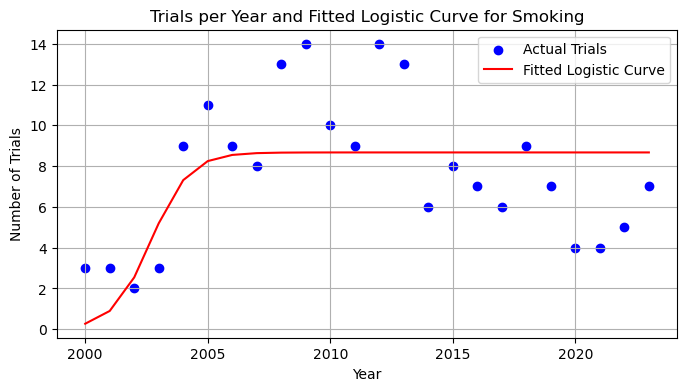

In [344]:
disease_name = 'Smoking'
# Filter for the specific disease
disease_data = df_unique_trials[df_unique_trials['Neurological Condition'] == disease_name]

# Check if there are enough data points
if len(disease_data) < min_trials:
    print(f"Not enough trials for {disease_name}. At least {min_trials} trials are required.")
    

# Group by year and count the trials
yearly_data = disease_data.groupby('start_year').size().reset_index(name='trials_count')

# Fit the logistic curve
years = yearly_data['start_year'].values
trials = yearly_data['trials_count'].values

# Initial parameter guesses
p0 = [max(trials), np.median(years), 1]  # L, t0, k
try:
    popt, _ = curve_fit(logistic_function, years, trials, p0=p0, maxfev=2000)

    L, t0, k = popt
    print(L, t0, k)
except Exception as e:
    print(f"Error fitting logistic function: {e}")
    

# Generate fitted values
fitted_trials = logistic_function(years, *popt)

# Plotting the results
plt.figure(figsize=(8, 4))
plt.scatter(years, trials, color='blue', label='Actual Trials')
plt.plot(years, fitted_trials, color='red', label='Fitted Logistic Curve')
plt.title(f'Trials per Year and Fitted Logistic Curve for {disease_name}')
plt.xlabel('Year')
plt.ylabel('Number of Trials')
plt.legend()
plt.grid(True)
plt.show()

In [347]:
df_unique_trials = aact_diseases[['nct_id', 'Neurological Condition','start_year']].drop_duplicates()

# Fit and evaluate logistic function for all conditions
results_df, unique_trials_per_year = fit_and_evaluate(df_unique_trials, min_trials=150, use_normalized_trials_count = False)
results_df

Nr of conditions  2811
Nr of conditions with more than 150 trials 71


,Disease,L,k,t0
0,Adjustment disorder,11669.232980,0.054452,2148.144774
1,Alzheimer's disease,65.103408,0.695913,2003.531384
2,Analgesia,49.445036,0.874439,2018.416732
3,Anxiety disorder,265994.736422,0.040616,2231.257966
4,Behavioral syndrome associated with\nphysiolog...,7862.897384,0.026808,2260.298294
...,...,...,...,...
66,Spinal cord disorder,31.723844,0.263332,2007.437590
67,Substance dependence,13.591794,-0.319223,2021.339852
68,Substance-related disorders,11.735376,-0.247842,2026.861241
69,Traumatic brain injury,18.792044,0.369637,2004.775261


In [348]:
results_df[results_df['Disease']=='Anxiety disorder']

,Disease,L,k,t0
3,Anxiety disorder,265994.736422,0.040616,2231.257966


In [360]:
len(unique_diseases)


16

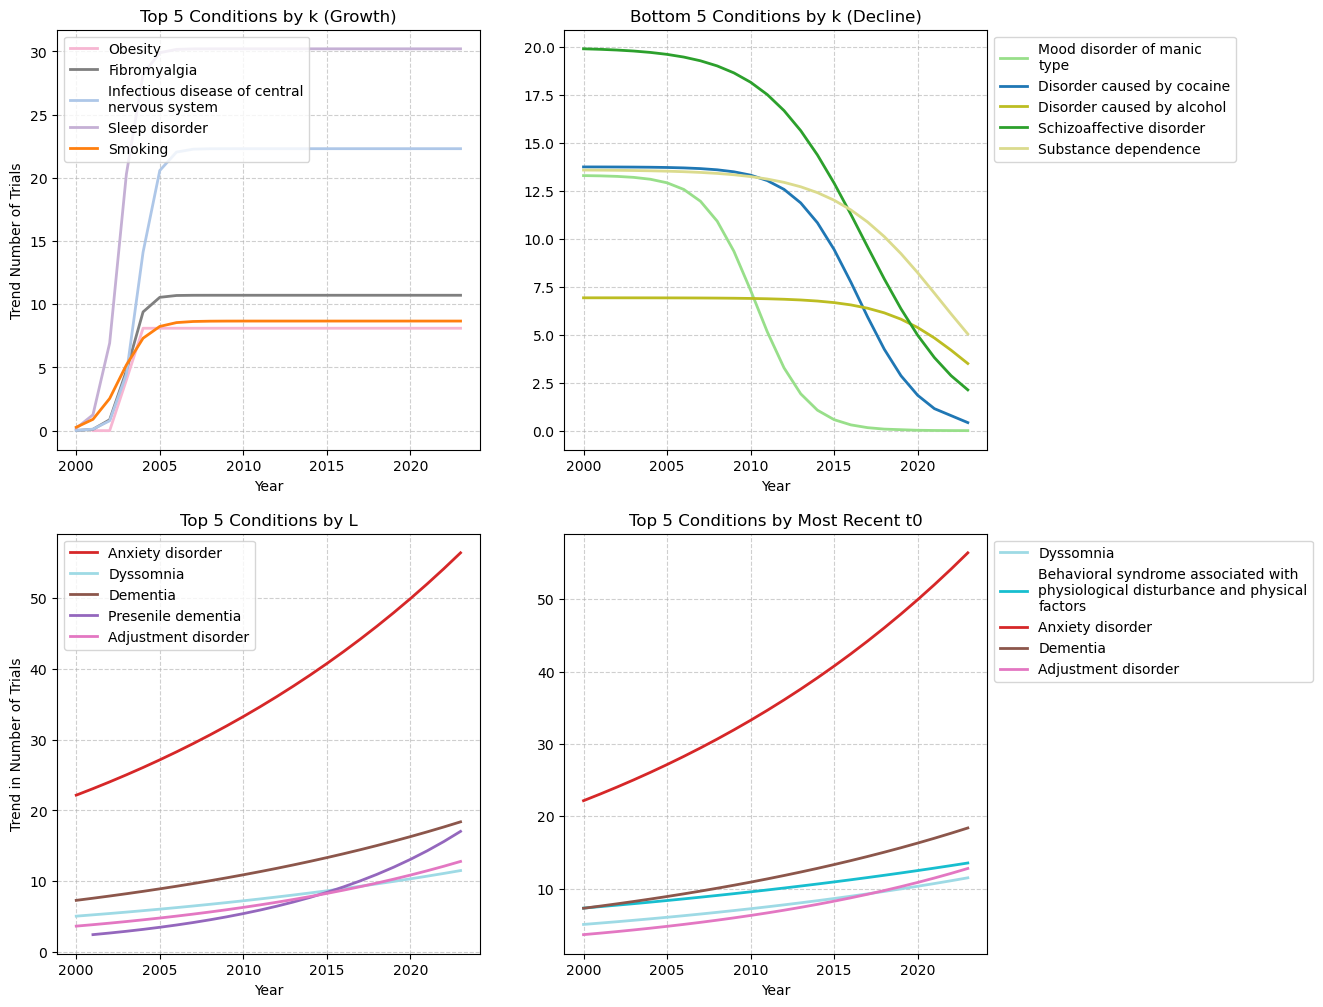

In [369]:
df = unique_trials_per_year.copy()

n_to_plot = 5

# Determine the most interesting trends
# Here we choose top 5 based on highest k, lowest k, highest L, and most recent t0
top_k = results_df.reindex(results_df['k'].nlargest(n_to_plot).index)  # Highest k values
bottom_k = results_df.reindex(results_df['k'].nsmallest(n_to_plot).index)  # Lowest k values (most negative)
top_L = results_df.reindex(results_df['L'].nlargest(n_to_plot).index)  # Highest L values
top_t0 = results_df.reindex(results_df['t0'].nlargest(n_to_plot).index)  # Most recent t0 values

# Gather all unique diseases from your filtered results
unique_diseases = set(top_k['Disease']).union(bottom_k['Disease'], top_L['Disease'], top_t0['Disease'])

# Custom color list provided
custom_colors = [
    "#000000", "#004949", "#009292", "#ff6db6", "#ffb6db",
    "#490092", "#006ddb", "#b66dff", "#6db6ff", "#b6dbff",
    "#920000", "#924900", "#db6d00", "#24ff24", "#ffff6d"
]

# Generate a colorblind-friendly color map
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_diseases)))  # Set2 provides distinct, colorblind-friendly colors
color_map = dict(zip(unique_diseases, colors))

# Create a color map with cycling through the custom colors
#color_map = {disease: custom_colors[i % len(custom_colors)] for i, disease in enumerate(unique_diseases)}

# Plot the fitted S-curves for top and bottom k conditions, highest L, and most recent t0
fig, axes = plt.subplots(2, 2, figsize=(12, 12))#, sharey=True)
linewidth = 2
# Plot for top k values
axes[0, 0].set_title('Top 5 Conditions by k (Growth)')
for index, row in top_k.iterrows():
    condition = row['Disease']
    condition_data = df[df['Neurological Condition'] == condition]
    years = condition_data['start_year'].values
    fitted_params = row[['L', 't0', 'k']].values
    trials = logistic_function(years, *fitted_params)
    axes[0, 0].plot(years, trials, label=condition,  color=color_map[condition], linewidth=linewidth) 
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Trend Number of Trials')
axes[0, 0].legend(loc='upper left', bbox_to_anchor=(0, 1))
axes[0, 0].grid(linestyle='--', alpha=0.6, zorder=1)

# Plot for bottom k values
axes[0, 1].set_title('Bottom 5 Conditions by k (Decline)')
for index, row in bottom_k.iterrows():
    condition = row['Disease']
    condition_data = df[df['Neurological Condition'] == condition]
    years = condition_data['start_year'].values
    fitted_params = row[['L', 't0', 'k']].values
    trials = logistic_function(years, *fitted_params)
    axes[0, 1].plot(years, trials, label=condition, color=color_map[condition], linewidth=linewidth) 
axes[0, 1].set_xlabel('Year')
axes[0, 1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[0, 1].grid(linestyle='--', alpha=0.6, zorder=1)

# Plot for highest L values
axes[1, 0].set_title('Top 5 Conditions by L')
for index, row in top_L.iterrows():
    condition = row['Disease']
    condition_data = df[df['Neurological Condition'] == condition]
    years = condition_data['start_year'].values
    fitted_params = row[['L', 't0', 'k']].values
    trials = logistic_function(years, *fitted_params)
    axes[1, 0].plot(years, trials, label=condition, color=color_map[condition], linewidth=linewidth) 
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Trend in Number of Trials')
axes[1, 0].legend(loc='upper left', bbox_to_anchor=(0, 1))
axes[1, 0].grid(linestyle='--', alpha=0.6, zorder=1)


# Plot for most recent t0 values
axes[1, 1].set_title('Top 5 Conditions by Most Recent t0')
for index, row in top_t0.iterrows():
    condition = row['Disease']
    condition_data = df[df['Neurological Condition'] == condition]
    years = condition_data['start_year'].values
    fitted_params = row[['L', 't0', 'k']].values
    trials = logistic_function(years, *fitted_params)
    axes[1, 1].plot(years, trials, label=condition,  color=color_map[condition], linewidth=linewidth) 
axes[1, 1].set_xlabel('Year')
axes[1, 1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1, 1].grid(linestyle='--', alpha=0.6, zorder=1)

#plt.suptitle('Fitted S-Curve for Top and Bottom Conditions by Various Metrics')
plt.show()

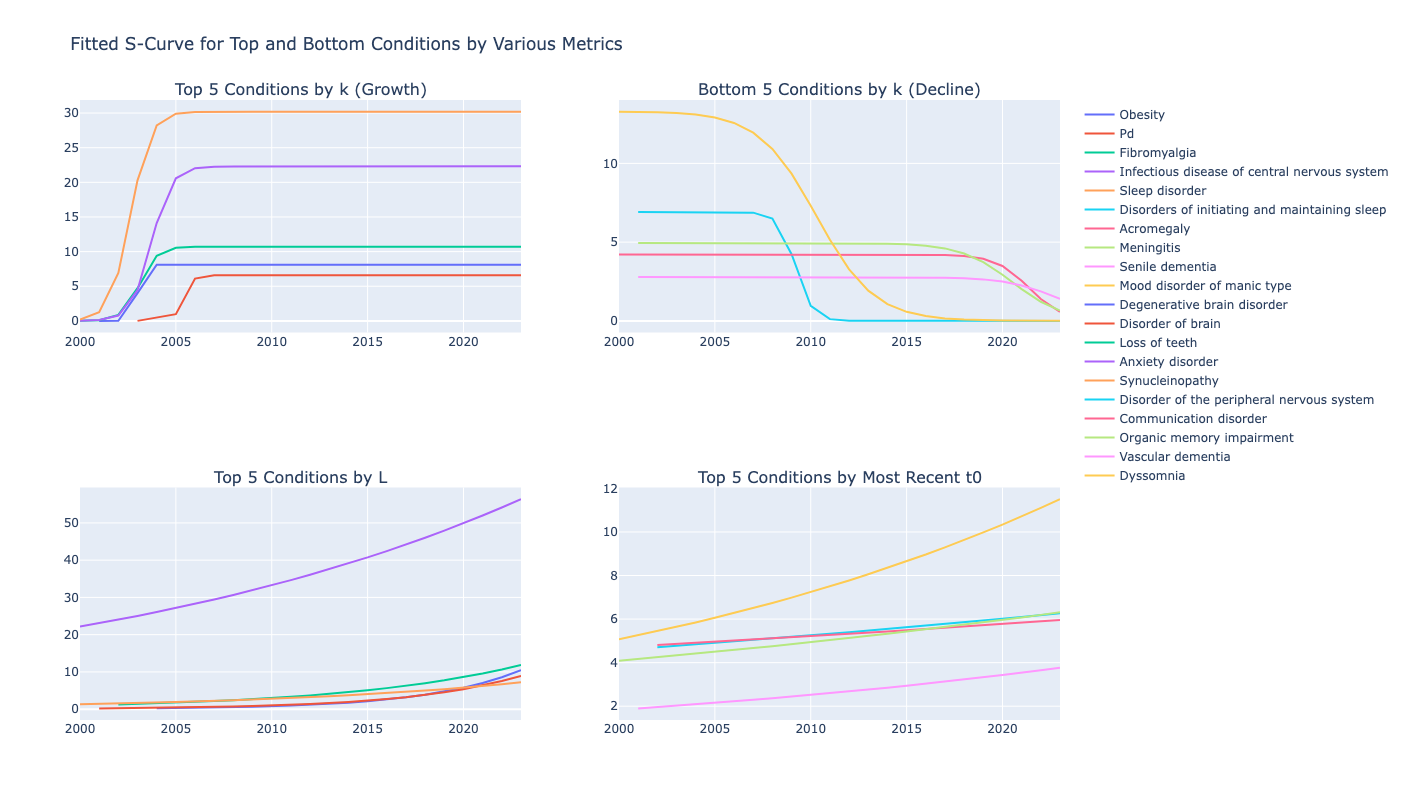

In [314]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2, subplot_titles=(
    'Top 5 Conditions by k (Growth)',
    'Bottom 5 Conditions by k (Decline)',
    'Top 5 Conditions by L',
    'Top 5 Conditions by Most Recent t0'
))

# Plot for top k values
for index, row in top_k.iterrows():
    condition = row['Disease']
    condition_data = df[df['Neurological Condition'] == condition]
    years = condition_data['start_year'].values
    fitted_params = row[['L', 't0', 'k']].values
    trials = logistic_function(years, *fitted_params)
    fig.add_trace(go.Scatter(x=years, y=trials, mode='lines', name=condition), row=1, col=1)

# Plot for bottom k values
for index, row in bottom_k.iterrows():
    condition = row['Disease']
    condition_data = df[df['Neurological Condition'] == condition]
    years = condition_data['start_year'].values
    fitted_params = row[['L', 't0', 'k']].values
    trials = logistic_function(years, *fitted_params)
    fig.add_trace(go.Scatter(x=years, y=trials, mode='lines', name=condition), row=1, col=2)

# Plot for highest L values
for index, row in top_L.iterrows():
    condition = row['Disease']
    condition_data = df[df['Neurological Condition'] == condition]
    years = condition_data['start_year'].values
    fitted_params = row[['L', 't0', 'k']].values
    trials = logistic_function(years, *fitted_params)
    fig.add_trace(go.Scatter(x=years, y=trials, mode='lines', name=condition), row=2, col=1)

# Plot for most recent t0 values
for index, row in top_t0.iterrows():
    condition = row['Disease']
    condition_data = df[df['Neurological Condition'] == condition]
    years = condition_data['start_year'].values
    fitted_params = row[['L', 't0', 'k']].values
    trials = logistic_function(years, *fitted_params)
    fig.add_trace(go.Scatter(x=years, y=trials, mode='lines', name=condition), row=2, col=2)

# Update layout
fig.update_layout(height=800, width=1000, title_text='Fitted S-Curve for Top and Bottom Conditions by Various Metrics')
fig.show()

In [282]:
print("Top conditions based on interesting trends:")
print("Top k values:")
top_k


Top conditions based on interesting trends:
Top k values:


,Disease,L,k,t0
160,Obesity,8.100000,21.627281,2003.001139
173,Pd,6.583018,4.295793,2005.407691
158,Nonneurogenic neurogenic urinary bladder\ndysf...,2.369081,2.565272,2004.139736
82,Fibromyalgia,10.709644,2.199967,2003.107237
105,Infectious disease of central\nnervous system,22.304900,1.932937,2003.717970


In [283]:
print("Bottom k values:")
bottom_k


Bottom k values:


,Disease,L,k,t0
122,Mania,2.846154,-14.835015,2017.958677
34,Chronic disease,2.000000,-9.585459,2023.000000
69,Disorders of initiating and\nmaintaining sleep,6.918362,-2.287319,2009.199312
0,Acromegaly,4.210445,-1.139240,2021.379465
127,Meningitis,4.937719,-0.748421,2020.501581


In [284]:
print("Top L values:")
top_L


Top L values:


,Disease,L,k,t0
50,Degenerative brain disorder,1.131224e+06,0.198746,2081.323157
62,Disorder of brain,5.275280e+05,0.171066,2087.215670
119,Loss of teeth,3.981755e+05,0.105959,2121.361749
12,Anxiety disorder,2.659947e+05,0.040616,2231.257966
219,Synucleinopathy,2.067288e+05,0.074272,2161.149927


In [285]:
print("Most recent t0 values:")
top_t0

Most recent t0 values:


,Disease,L,k,t0
174,Perimenopausal disorder,531.279350,0.003828,3476.769180
222,Tobacco,251.461968,0.008870,2557.923141
67,Disorder of the peripheral\nnervous system,7199.890542,0.013589,2541.491629
43,Communication disorder,320.795981,0.010319,2407.541769
165,Organic memory impairment,4905.342172,0.018877,2375.527300


In [126]:
results_df[results_df['Neurological Condition']=='Schizophrenia']

,Neurological Condition,L,k,t0
518,Schizophrenia,0.582091,-0.374518,2019.195198


### Percentage growth

In [237]:
from datetime import datetime

In [239]:
sorted_pivot_df

,Neurological Condition,2013,2023,percentage_growth
2,Analgesia,4.0,37.0,825.000000
25,Degenerative disorder of muscle,5.0,36.0,620.000000
36,Dyssomnia,2.0,14.0,600.000000
88,Sarcopenia,6.0,37.0,516.666667
56,Loss of teeth,2.0,10.0,400.000000
...,...,...,...,...
105,Traumatic or nontraumatic brain\ninjury,7.0,3.0,-57.142857
89,Schizoaffective disorder,13.0,5.0,-61.538462
86,Recurrent disease,9.0,3.0,-66.666667
17,Cocaine,8.0,2.0,-75.000000


In [371]:
df = aact_diseases.copy()

# Convert start_year to int
df['start_year'] = df['start_year'].astype(int)

# Filter data for the years 2013, 2018, 2020, and 2023
df_filtered = df[df['start_year'].isin([2013, 2018, 2020, 2023])]

# Remove duplicate trials based on nct_id and Neurological Condition
df_unique_trials = df_filtered.drop_duplicates(subset=['nct_id', 'Neurological Condition'])

# Filter conditions with sufficient data
condition_counts = df_unique_trials['Neurological Condition'].value_counts()
df_unique_trials = df_unique_trials[df_unique_trials['Neurological Condition'].isin(condition_counts[condition_counts >= 10].index)]

# Group by Neurological Condition and start_year, and count unique trials
unique_trials_per_year = df_unique_trials.groupby(['Neurological Condition', 'start_year']).size().reset_index(name='unique_trials_count')

# Pivot the data for easier comparison
pivot_df = unique_trials_per_year.pivot(index='Neurological Condition', columns='start_year', values='unique_trials_count').fillna(0)

# Flatten the DataFrame so that 'Neurological Condition' and 'start_year' are on the same level
pivot_df.columns = [str(col) for col in pivot_df.columns]
pivot_df.reset_index(inplace=True)

def calculate_growth(row, start_year, end_year):
    start_trials = row[str(start_year)]
    end_trials = row[str(end_year)]
    if start_trials == 0:
        return 100 if end_trials > 0 else 0
    return ((end_trials - start_trials) / start_trials) * 100

# Calculate growth rates for different time spans
pivot_df['3_year_growth'] = pivot_df.apply(lambda row: calculate_growth(row, 2020, 2023), axis=1)
pivot_df['5_year_growth'] = pivot_df.apply(lambda row: calculate_growth(row, 2018, 2023), axis=1)
pivot_df['10_year_growth'] = pivot_df.apply(lambda row: calculate_growth(row, 2013, 2023), axis=1)

# Fill NaN values with 0
pivot_df.fillna(0, inplace=True)

# Sorting the DataFrame by one of the growth metrics for review
sorted_pivot_df = pivot_df.sort_values(by='10_year_growth', ascending=False)

In [373]:
sorted_pivot_df.head(10)

,Neurological Condition,2013,2018,2020,2023,3_year_growth,5_year_growth,10_year_growth
5,Analgesia,4.0,14.0,44.0,37.0,-15.909091,164.285714,825.000000
99,Mechanical complication of device,1.0,4.0,6.0,8.0,33.333333,100.000000,700.000000
174,Synucleinopathy,1.0,5.0,8.0,8.0,0.000000,60.000000,700.000000
37,Degenerative disorder of muscle,5.0,23.0,9.0,36.0,300.000000,56.521739,620.000000
19,Cerebrovascular disease,1.0,2.0,5.0,7.0,40.000000,250.000000,600.000000
61,Dyssomnia,2.0,10.0,11.0,14.0,27.272727,40.000000,600.000000
153,Sarcopenia,6.0,18.0,12.0,37.0,208.333333,105.555556,516.666667
175,Thrombosis,1.0,5.0,3.0,6.0,100.000000,20.000000,500.000000
32,Complication of surgical procedure,1.0,2.0,7.0,6.0,-14.285714,200.000000,500.000000
66,Fibrillation,1.0,3.0,5.0,5.0,0.000000,66.666667,400.000000


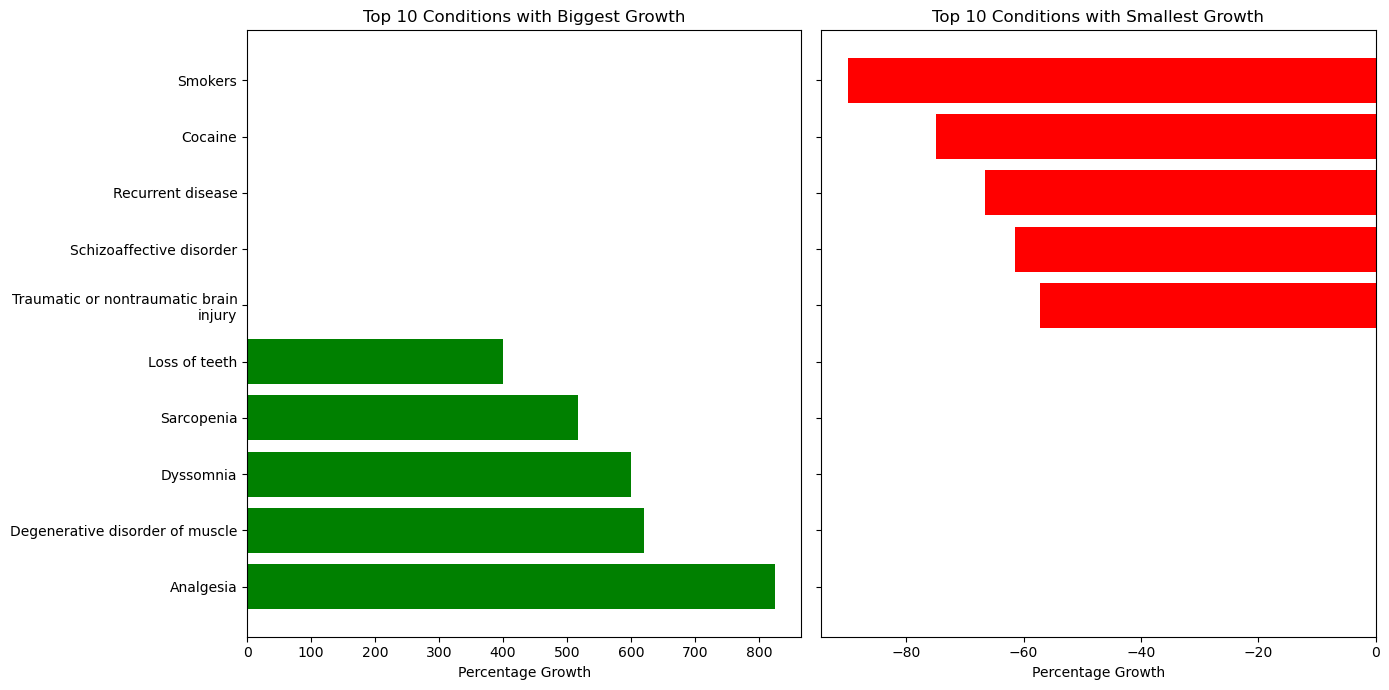

In [240]:
# Top 10 conditions with biggest growth
top_10_biggest_growth = sorted_pivot_df.head(5)

# Top 10 conditions with smallest growth
top_10_smallest_growth = sorted_pivot_df.tail(5)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), sharey=True)

# Plot for biggest growth
axes[0].barh(top_10_biggest_growth['Neurological Condition'], top_10_biggest_growth['percentage_growth'], color='green')
axes[0].set_title('Top 10 Conditions with Biggest Growth')
axes[0].set_xlabel('Percentage Growth')
axes[0].invert_yaxis()  # highest values at the top

# Plot for smallest growth
axes[1].barh(top_10_smallest_growth['Neurological Condition'], top_10_smallest_growth['percentage_growth'], color='red')
axes[1].set_title('Top 10 Conditions with Smallest Growth')
axes[1].set_xlabel('Percentage Growth')
axes[1].invert_yaxis()  # lowest values at the top

plt.tight_layout()
plt.show()

In [225]:
sorted_pivot_df

start_year,2013,2023,percentage_growth
Neurological Condition,,,
Analgesia,4.0,37.0,825.000000
Degenerative disorder of muscle,5.0,36.0,620.000000
Dyssomnia,2.0,14.0,600.000000
Sarcopenia,6.0,37.0,516.666667
Loss of teeth,2.0,10.0,400.000000
...,...,...,...
Traumatic or nontraumatic brain\ninjury,7.0,3.0,-57.142857
Schizoaffective disorder,13.0,5.0,-61.538462
Recurrent disease,9.0,3.0,-66.666667


# Interventions

In [1911]:
import textwrap


In [1912]:
viz_path_interventions = Path("viz/interventions/")

In [1913]:
aact_disease_intervention = reference_data[['nct_id', condition_col_name, 'Disease Class', drug_col_name, 'intervention_type', 'phase', 'overall_status', 'start_year']]

In [1914]:
#filtered_df = aact_disease_intervention[(aact_disease_intervention['intervention_type'] == 'Drug') | (aact_disease_intervention['intervention_type'] == 'Biological')]
#filtered_df = aact_disease_intervention[(aact_disease_intervention['intervention_name'] != 'Saline') & (aact_disease_intervention['intervention_type'] != 'Normal saline')]
#filtered_df.head(10)

In [1915]:
aact_disease_intervention[drug_col_name].isnull().sum()

0

In [1916]:
aact_disease_intervention.dropna(subset=[drug_col_name], inplace=True)
aact_disease_intervention.drop(aact_disease_intervention[aact_disease_intervention[drug_col_name] == ''].index, inplace=True)

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_72586/1930621683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aact_disease_intervention.dropna(subset=[drug_col_name], inplace=True)
/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_72586/1930621683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aact_disease_intervention.drop(aact_disease_intervention[aact_disease_intervention[drug_col_name] == ''].index, inplace=True)


In [1917]:
# Keeping only unique nct_id, phase pairs
unique_pairs = aact_disease_intervention[['nct_id', drug_col_name]].drop_duplicates()

# Counting the number of nct_ids per phase type
drug_counts = unique_pairs[drug_col_name].value_counts()
drug_counts

Drug Intervention
Risperidone                                   341
Levodopa                                      294
Anti-psychotic agent                          266
Ketamine                                      265
Olanzapine                                    259
                                             ... 
Tbe vaccination                                 1
Tick-borne encephalitis                         1
Lamotrigine tablets in epileptic\npatients      1
Monovalent polio vaccine                        1
Siderite                                        1
Name: count, Length: 7540, dtype: int64

In [1918]:
drug_counts[:30]

Drug Intervention
Risperidone                                                          341
Levodopa                                                             294
Anti-psychotic agent                                                 266
Ketamine                                                             265
Olanzapine                                                           259
Aripiprazole                                                         240
Carbidopa                                                            234
Dexmedetomidine                                                      233
Quetiapine                                                           219
Donepezil                                                            173
Nicotine                                                             165
Substance with serotonin re-uptake\ninhibitor mechanism of action    164
Clostridium botulinum toxin                                          161
Botulinum toxin type A           

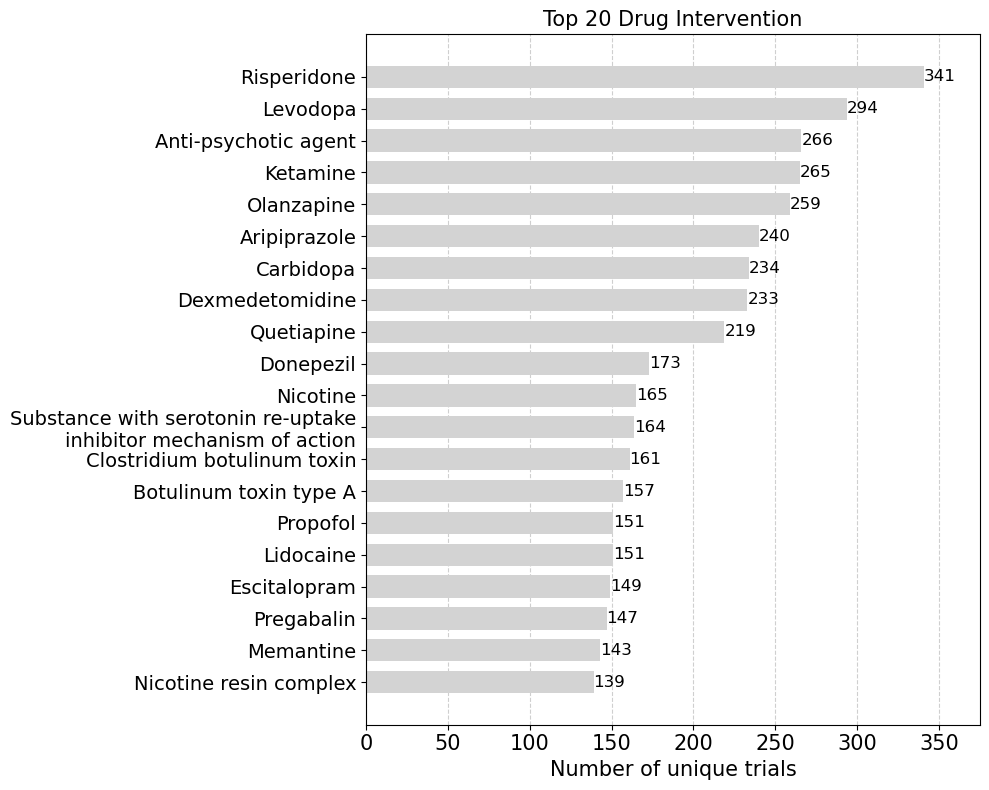

In [1919]:
plot_entity_frequency(aact_disease_intervention, drug_col_name, 'interventions', annotations_type, viz_path_interventions, top_n=20)


In [1920]:
# Aggregate trials by disease and phase, counting unique nct_ids
intervention_phase_counts = aact_disease_intervention.groupby([drug_col_name, 'phase'])['nct_id'].nunique().reset_index()

#intervention_phase_counts_filtered = intervention_phase_counts[intervention_phase_counts['phase'] != 'Not Applicable']

# Pivot the filtered data to have interventions as rows and phases as columns
pivot_intervention_df_filtered = intervention_phase_counts.pivot(index=drug_col_name, columns='phase', values='nct_id').fillna(0)

# Calculate total trials per intervention again without 'Not Applicable' phase
pivot_intervention_df_filtered['Total Trials'] = pivot_intervention_df_filtered.sum(axis=1)
top_interventions_filtered = pivot_intervention_df_filtered.sort_values('Total Trials', ascending=False).head(20)
top_interventions_filtered

phase,Early Phase 1,Not Applicable,Phase 1,Phase 1/Phase 2,Phase 2,Phase 2/Phase 3,Phase 3,Phase 4,Total Trials
Drug Intervention,,,,,,,,,
Risperidone,1.0,37.0,31.0,8.0,39.0,8.0,81.0,136.0,341.0
Levodopa,2.0,25.0,48.0,12.0,77.0,11.0,70.0,49.0,294.0
Anti-psychotic agent,1.0,52.0,18.0,6.0,28.0,6.0,49.0,106.0,266.0
Ketamine,14.0,51.0,36.0,13.0,58.0,16.0,19.0,58.0,265.0
Olanzapine,1.0,35.0,8.0,5.0,31.0,2.0,72.0,105.0,259.0
Aripiprazole,1.0,24.0,19.0,3.0,26.0,4.0,64.0,99.0,240.0
Carbidopa,2.0,8.0,81.0,8.0,72.0,11.0,32.0,20.0,234.0
Dexmedetomidine,7.0,70.0,7.0,8.0,17.0,8.0,23.0,93.0,233.0
Quetiapine,1.0,20.0,8.0,3.0,17.0,4.0,76.0,90.0,219.0


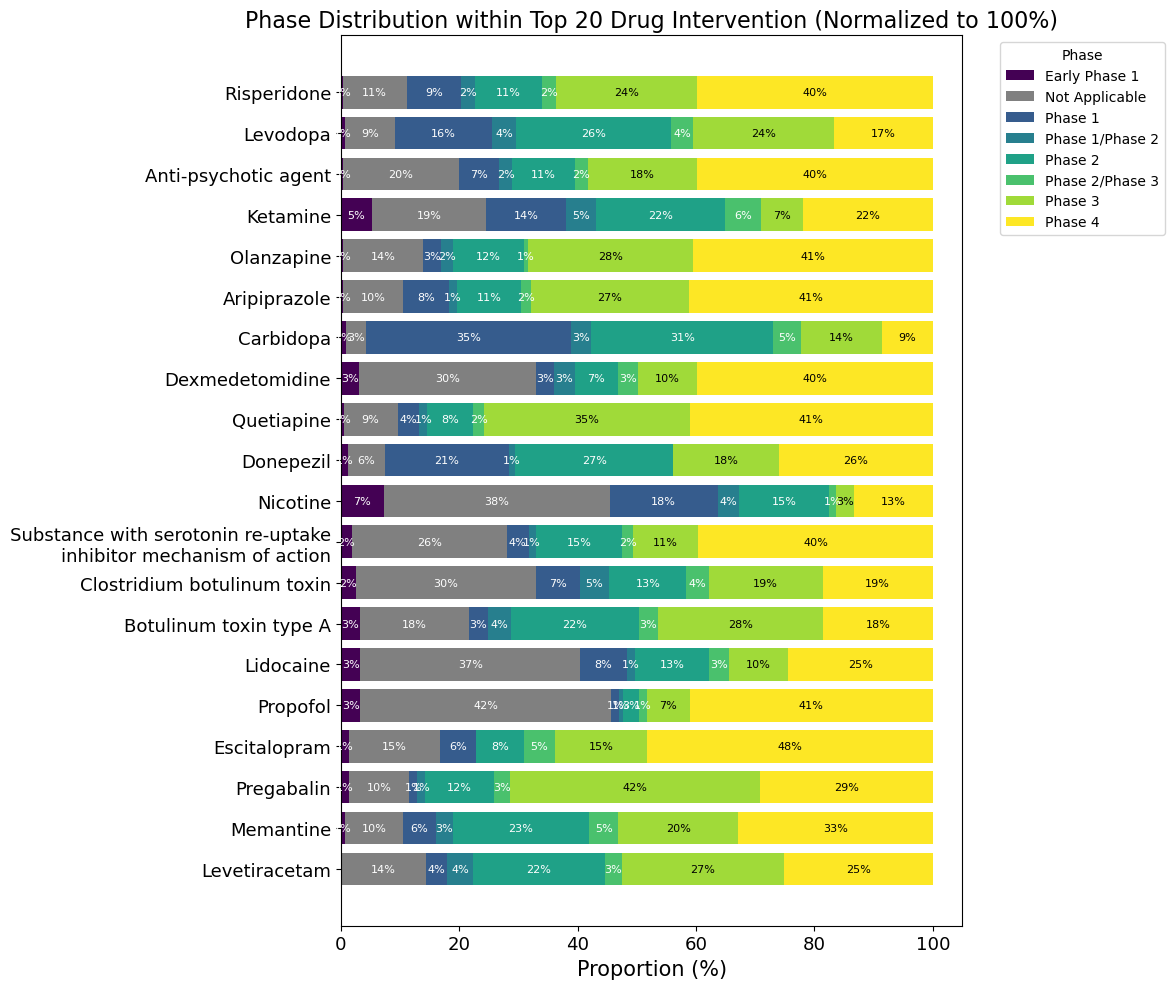

In [1921]:
plot_phase_distribution(aact_disease_intervention, drug_col_name, 'interventions', 'phase', 'nct_id', annotations_type, viz_path_interventions, top_n=20)


In [1922]:
aact_disease_intervention

,nct_id,Neurological Condition,Disease Class,Drug Intervention,intervention_type,phase,overall_status,start_year
382,NCT00000307,Disorder caused by alcohol,Diseases Category,Naltrexone,Drug,Phase 2,Completed,2003.0
382,NCT00000307,Disorder caused by cocaine,Diseases Category,Naltrexone,Drug,Phase 2,Completed,2003.0
383,NCT00000307,Disorder caused by alcohol,Diseases Category,Naltrexone,Drug,Phase 2,Completed,2003.0
383,NCT00000307,Disorder caused by cocaine,Diseases Category,Naltrexone,Drug,Phase 2,Completed,2003.0
384,NCT00000307,Disorder caused by alcohol,Diseases Category,Naltrexone,Drug,Phase 2,Completed,2003.0
...,...,...,...,...,...,...,...,...
262609,NCT06293586,Strabismus,Cranial Nerve Diseases,Paracetamol,Procedure,Not Applicable,Recruiting,2023.0
262610,NCT06293586,Acute disease of cardiovascular\nsystem,Cranial Nerve Diseases,Paracetamol,Drug,Not Applicable,Recruiting,2023.0
262610,NCT06293586,Congenital malformation,Cranial Nerve Diseases,Paracetamol,Drug,Not Applicable,Recruiting,2023.0
262610,NCT06293586,Perioperative complication,Cranial Nerve Diseases,Paracetamol,Drug,Not Applicable,Recruiting,2023.0


yearly totals
start_year
2000.0     136
2001.0     235
2002.0     315
2003.0     515
2004.0     660
2005.0     728
2006.0     822
2007.0     813
2008.0     869
2009.0     904
2010.0     865
2011.0     824
2012.0     807
2013.0     772
2014.0     877
2015.0     904
2016.0     862
2017.0     900
2018.0     901
2019.0     964
2020.0     901
2021.0    1077
2022.0    1005
2023.0     947
Name: nct_id, dtype: int64


/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_72586/1695848084.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])


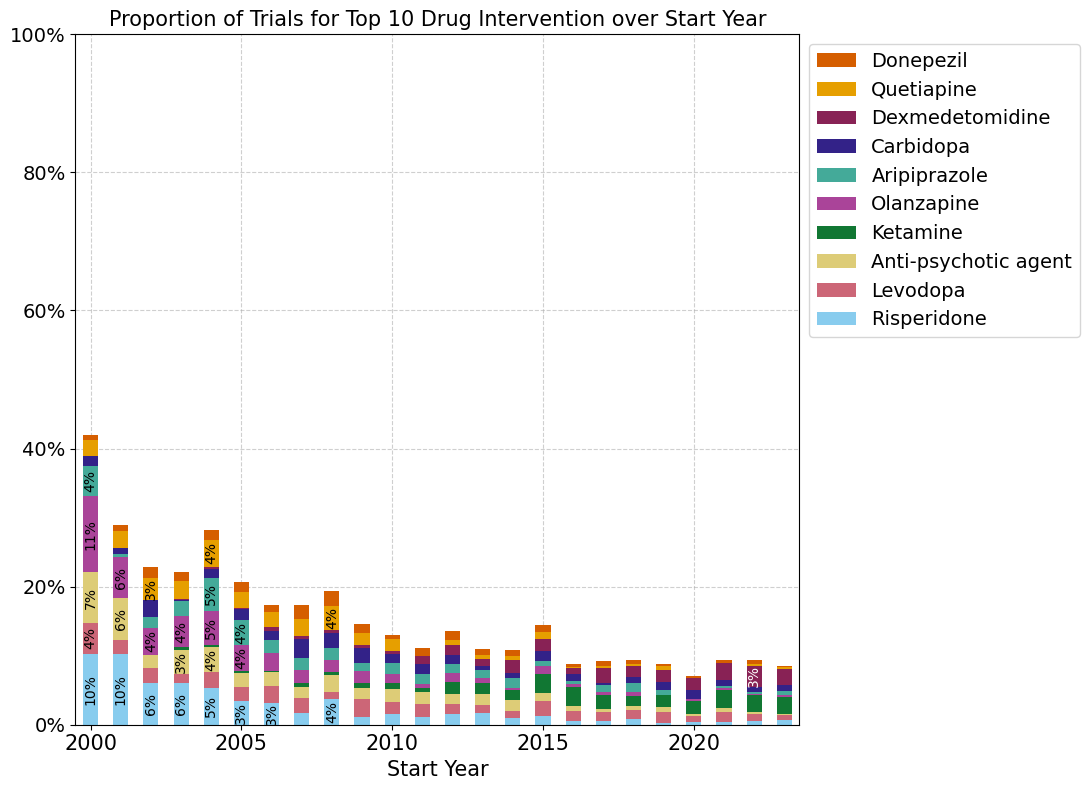

In [1923]:
plot_stacked_over_time_global_totals(aact_disease_intervention, drug_col_name, 'interventions', 'start_year', 'nct_id', annotations_type, viz_path_interventions, top_n=10, custom_palette = custom_colors)


/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_72586/1530534109.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])


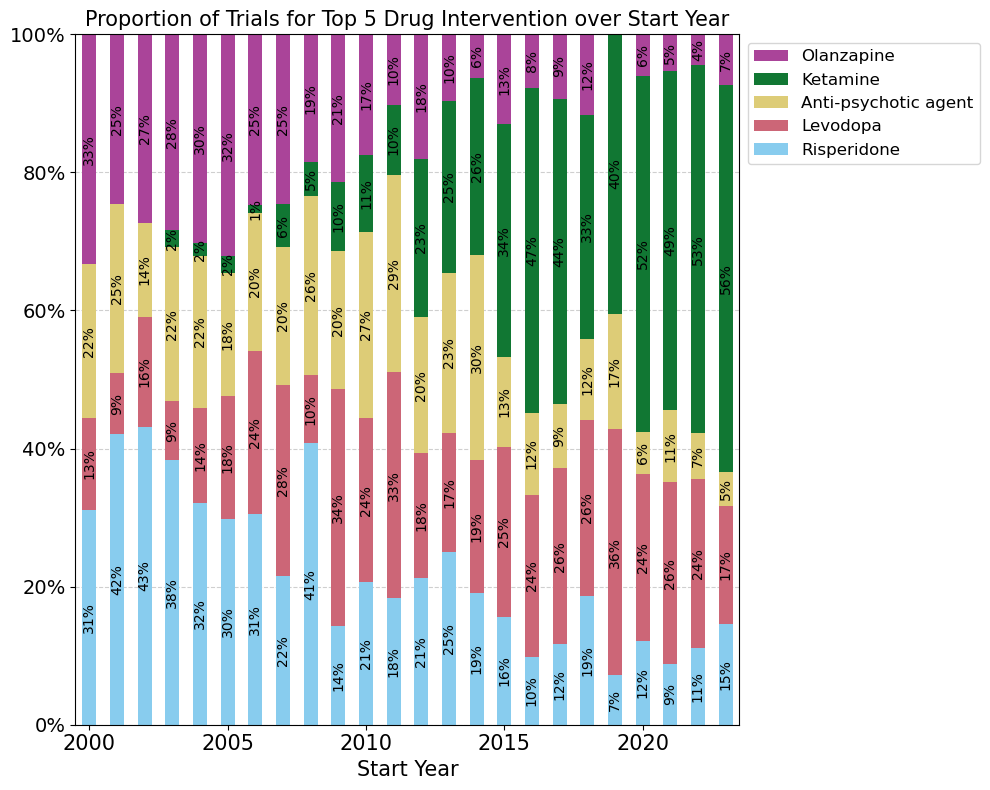

In [1924]:
plot_stacked_over_time(aact_disease_intervention, drug_col_name, 'interventions', 'start_year', 'nct_id', annotations_type, viz_path_interventions, top_n=5, custom_palette = custom_colors)


Drug Intervention
Risperidone             341
Levodopa                294
Anti-psychotic agent    266
Ketamine                265
Olanzapine              259
Name: count, dtype: int64


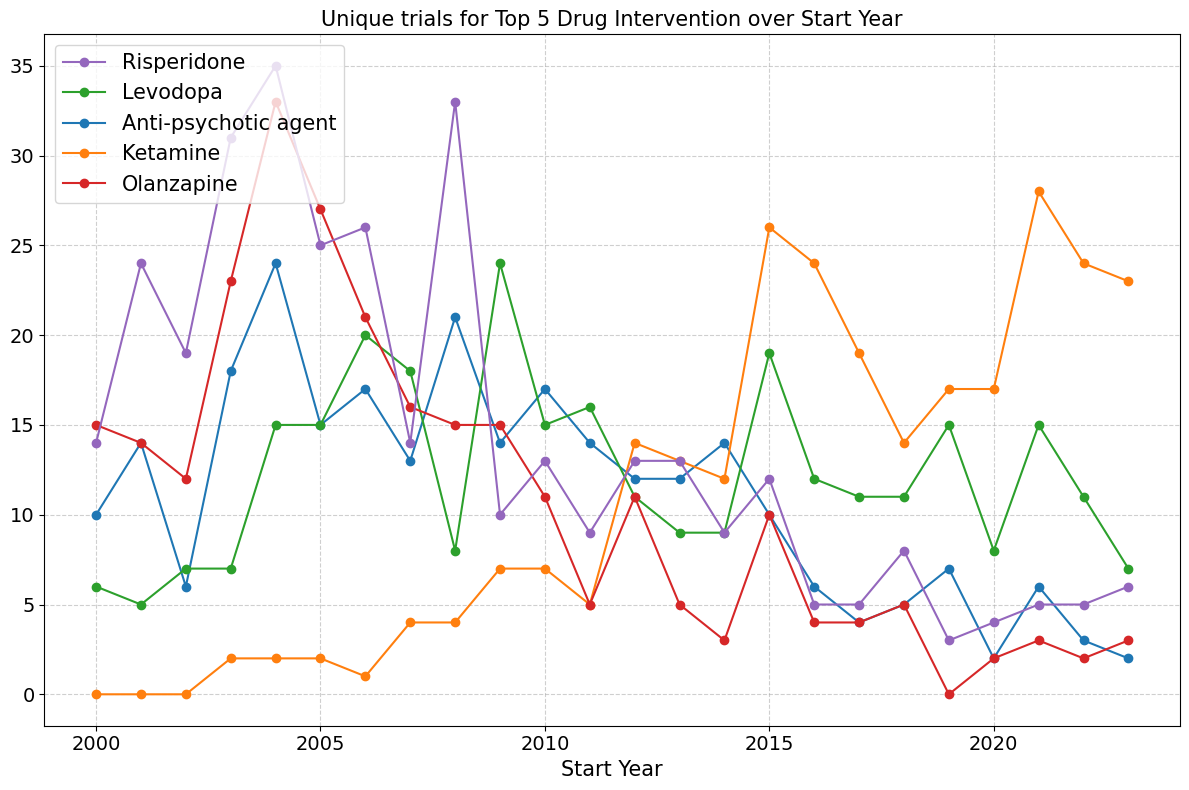

In [1925]:
plot_distribution_over_time(aact_disease_intervention, drug_col_name, 'interventions', 'start_year', 'nct_id', annotations_type, viz_path_interventions, top_n=5)


## Intervention/ Disease

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_72586/1797141630.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_unique['disease_intervention_pair'] = filtered_df_unique[condition_col_name] + ' - ' + filtered_df_unique[drug_col_name]


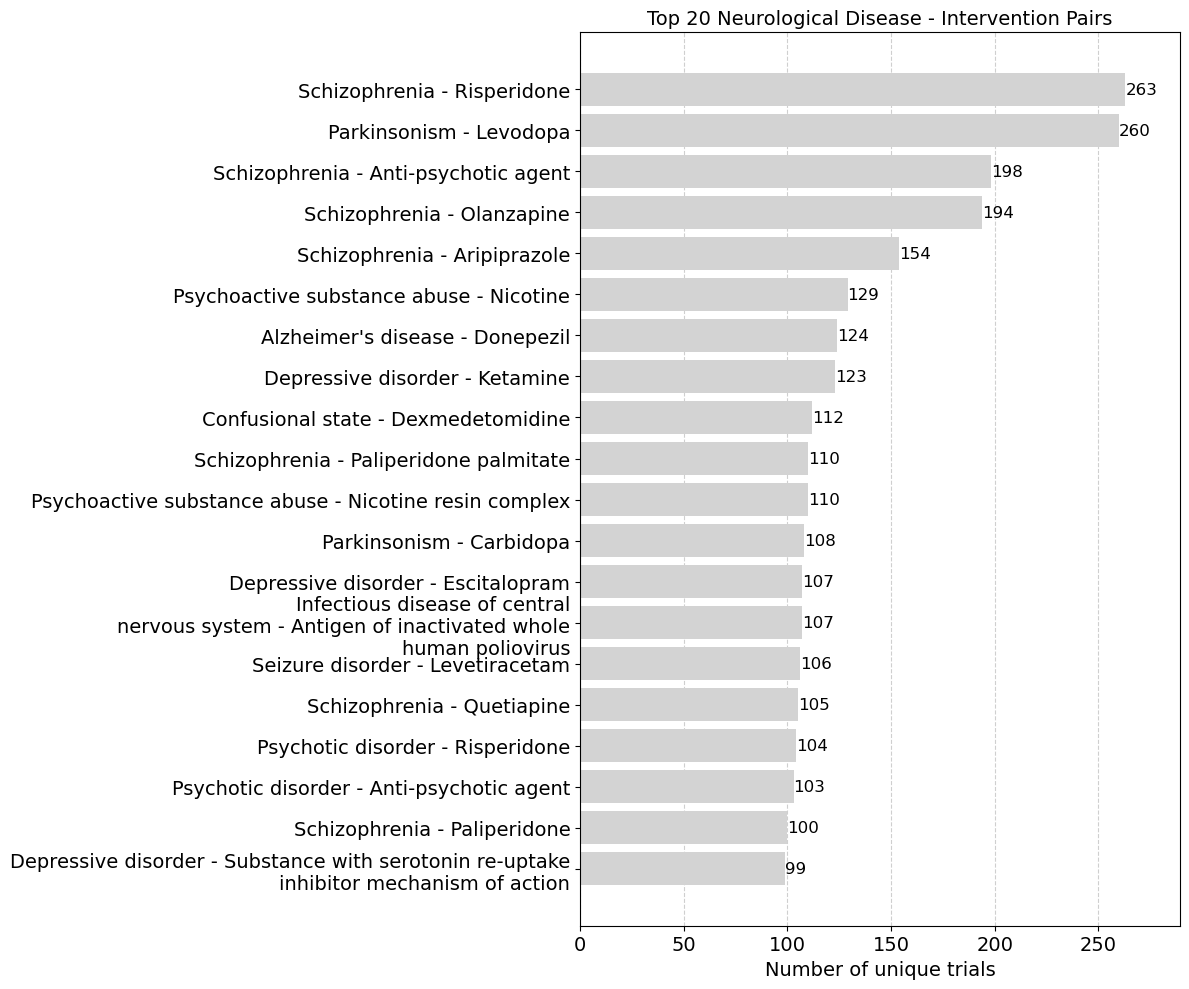

In [1864]:
filtered_df = aact_disease_intervention.copy()

# Normalize drug_col_name to start with a capital letter
filtered_df[drug_col_name] = filtered_df[drug_col_name].str.capitalize()

# Drop duplicates based on 'nct_id' to ensure uniqueness
filtered_df_unique = filtered_df.drop_duplicates(subset=['nct_id', condition_col_name, drug_col_name])

# Create pairs of unique 'nct_id'
filtered_df_unique['disease_intervention_pair'] = filtered_df_unique[condition_col_name] + ' - ' + filtered_df_unique[drug_col_name]

# Count the frequency of each unique pair
pair_counts_unique = filtered_df_unique['disease_intervention_pair'].value_counts()

# Select the top 20 most frequent pairs
top_20_pairs_unique = pair_counts_unique.head(20).sort_values(ascending=True)  # Sort ascending for plot layout

# Plot with specified formatting
plt.figure(figsize=(12, 10))
bars = plt.barh(top_20_pairs_unique.index, top_20_pairs_unique, color='lightgrey', zorder=2)

# Add labels to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width}', va='center', fontsize=12)

plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
plt.xlabel('Number of unique trials', fontsize=14)
plt.title(f'Top 20 Neurological Disease - Intervention Pairs', fontsize=14)
plt.tight_layout()
plt.xlim(0, max(pair_counts_unique) + max(pair_counts_unique)/10)  # Adjusted to max count for relevancy

# Save the plot to a local folder
plt.savefig(f'viz/disease_intervention_pair_frequency_{annotations_type}.png')

plt.show()


In [1865]:
filtered_df_unique[filtered_df_unique['Neurological Condition']=="Alzheimer's disease"]

,nct_id,Neurological Condition,Disease Class,Drug Intervention,intervention_type,phase,overall_status,start_year,disease_intervention_pair
3332,NCT00007189,Alzheimer's disease,Neurodegenerative Diseases,Celecoxib,Drug,Phase 3,Completed,2001.0,Alzheimer's disease - Celecoxib
3332,NCT00007189,Alzheimer's disease,Neurodegenerative Diseases,Naproxen,Drug,Phase 3,Completed,2001.0,Alzheimer's disease - Naproxen
3332,NCT00007189,Alzheimer's disease,Neurodegenerative Diseases,Naproxen sodium,Drug,Phase 3,Completed,2001.0,Alzheimer's disease - Naproxen sodium
3332,NCT00007189,Alzheimer's disease,Neurodegenerative Diseases,Non-steroidal anti-inflammatory agent,Drug,Phase 3,Completed,2001.0,Alzheimer's disease - Non-steroidal anti-infla...
3381,NCT00009191,Alzheimer's disease,Neurodegenerative Diseases,Sertraline,Drug,Phase 4,Completed,2005.0,Alzheimer's disease - Sertraline
...,...,...,...,...,...,...,...,...,...
261153,NCT06194552,Alzheimer's disease,Neurodegenerative Diseases,Methylnaltrexone bromide,Drug,Phase 1,Completed,2022.0,Alzheimer's disease - Methylnaltrexone bromide
261376,NCT06217146,Alzheimer's disease,Psychiatry and Psychology Category,Cannabis,Drug,Not Applicable,Recruiting,2022.0,Alzheimer's disease - Cannabis
261706,NCT06234436,Alzheimer's disease,Neurodegenerative Diseases,Plasma substitutes,Biological,Early Phase 1,Enrolling by invitation,2023.0,Alzheimer's disease - Plasma substitutes
262587,NCT06292351,Alzheimer's disease,Neurodegenerative Diseases,Dimetan,Drug,Phase 2/Phase 3,Recruiting,2023.0,Alzheimer's disease - Dimetan


In [1866]:
filtered_df_unique[filtered_df_unique['nct_id']=="NCT01760005"]

,nct_id,Neurological Condition,Disease Class,Drug Intervention,intervention_type,phase,overall_status,start_year,disease_intervention_pair
128084,NCT01760005,Alzheimer's disease,Diseases of the nervous system|Central Nervous...,Crizanlizumab,Drug,Phase 2/Phase 3,Recruiting,2012.0,Alzheimer's disease - Crizanlizumab
128084,NCT01760005,Dementia,Diseases of the nervous system|Central Nervous...,Crizanlizumab,Drug,Phase 2/Phase 3,Recruiting,2012.0,Dementia - Crizanlizumab
128084,NCT01760005,Familial disease,Diseases of the nervous system|Central Nervous...,Crizanlizumab,Drug,Phase 2/Phase 3,Recruiting,2012.0,Familial disease - Crizanlizumab
128084,NCT01760005,Alzheimer's disease,Diseases of the nervous system|Central Nervous...,Gliadin antibody,Drug,Phase 2/Phase 3,Recruiting,2012.0,Alzheimer's disease - Gliadin antibody
128084,NCT01760005,Dementia,Diseases of the nervous system|Central Nervous...,Gliadin antibody,Drug,Phase 2/Phase 3,Recruiting,2012.0,Dementia - Gliadin antibody
128084,NCT01760005,Familial disease,Diseases of the nervous system|Central Nervous...,Gliadin antibody,Drug,Phase 2/Phase 3,Recruiting,2012.0,Familial disease - Gliadin antibody
128084,NCT01760005,Alzheimer's disease,Diseases of the nervous system|Central Nervous...,Monosodium glutamate,Drug,Phase 2/Phase 3,Recruiting,2012.0,Alzheimer's disease - Monosodium glutamate
128084,NCT01760005,Dementia,Diseases of the nervous system|Central Nervous...,Monosodium glutamate,Drug,Phase 2/Phase 3,Recruiting,2012.0,Dementia - Monosodium glutamate
128084,NCT01760005,Familial disease,Diseases of the nervous system|Central Nervous...,Monosodium glutamate,Drug,Phase 2/Phase 3,Recruiting,2012.0,Familial disease - Monosodium glutamate
128084,NCT01760005,Alzheimer's disease,Diseases of the nervous system|Central Nervous...,Sacituzumab,Drug,Phase 2/Phase 3,Recruiting,2012.0,Alzheimer's disease - Sacituzumab


In [1628]:
disease_intervenion_pairs = filtered_df_unique[['nct_id', 'disease_intervention_pair']].drop_duplicates()

In [1629]:
disease_intervenion_pairs.to_csv(f"./analysis/disease_intervenion_pairs_{annotations_type}.csv")


In [1630]:
aact_disease_intervention_with_entity_tags = reference_data_with_entity_tags[['nct_id', condition_col_name, 'Disease Class', drug_col_name, 'intervention_type', 'phase', 'overall_status', 'start_year']]
filtered_df = aact_disease_intervention_with_entity_tags.copy()

In [1870]:
filtered_df_unique.groupby('Neurological Condition')['Drug Intervention'].nunique().sort_values(ascending=False)

Neurological Condition
Depressive disorder                            1127
Neoplastic disease                             1106
Alzheimer's disease                            1076
Infectious disease                             1009
Schizophrenia                                   920
                                               ... 
Nonsense mutations                                1
Bp1                                               1
Bp-nos                                            1
Norepinephrine serotonin reuptake inhibitor       1
&                                                 1
Name: Drug Intervention, Length: 2811, dtype: int64

In [1876]:
depressive_disorder_interventions = filtered_df_unique[filtered_df_unique['Neurological Condition'] == 'Depressive disorder']['Drug Intervention'].unique()
depressive_disorder_interventions

array(['Naltrexone', 'Sertraline', 'Cisplatin', ..., 'Anti jo-1 antibody',
       'Antigen of inactivated whole\njapanese encephalitis virus adsorbed',
       'Js1-1-01 high-dose group'], dtype=object)

In [1877]:
depressive_disorder_interventions = filtered_df_unique[filtered_df_unique['Neurological Condition'] == 'Neoplastic disease']['Drug Intervention'].unique()
depressive_disorder_interventions

array(['Temozolomide', 'Cisplatin', 'Fluoxetine', ...,
       'Immune suppressor gene', 'Loperamide hydrochloride',
       'Loperamide oxide'], dtype=object)

In [1927]:
depressive_disorder_interventions = filtered_df_unique[filtered_df_unique['Neurological Condition'] == 'Schizophrenia']['Drug Intervention'].unique()
depressive_disorder_interventions[:100]

array(['Amino acid', 'Glycine', 'Anti-psychotic agent',
       'Atypical antipsychotics', 'Clozapine', 'Fluphenazine decanoate',
       'Olanzapine', 'Perphenazine', 'Quetiapine', 'Risperidone',
       'Ziprasidone', 'Quetiapine fumarate', 'Aripiprazole', 'Lurasidone',
       'Lurasidone hydrochloride', 'Oxiconazole nitrate', 'Haloperidol',
       'Haloperidol 10mg', 'Entacapone', 'Talbutal', 'Tolcapone',
       'Sibutramine', 'Nicotine', 'Nicotine resin complex', 'Citalopram',
       'Talc', 'Molindone', 'Modafinil',
       'Acetylcholine receptor binding antibody', 'Blood group antigen a',
       'Potassium iodide', 'Potassium perchlorate', 'Protein z antigen',
       'Rissole', 'Terconazole', 'Lamotrigine', 'Valproate',
       'Valproate semisodium', 'Valproic acid', 'Paliperidone',
       'Paliperidone palmitate', 'Galantamine',
       'Galantamine hydrobromide', 'Atypical', 'Olanzapine embonate',
       'Memantine', 'Memantine hydrochloride',
       'Substance with n-methyl-d-aspa

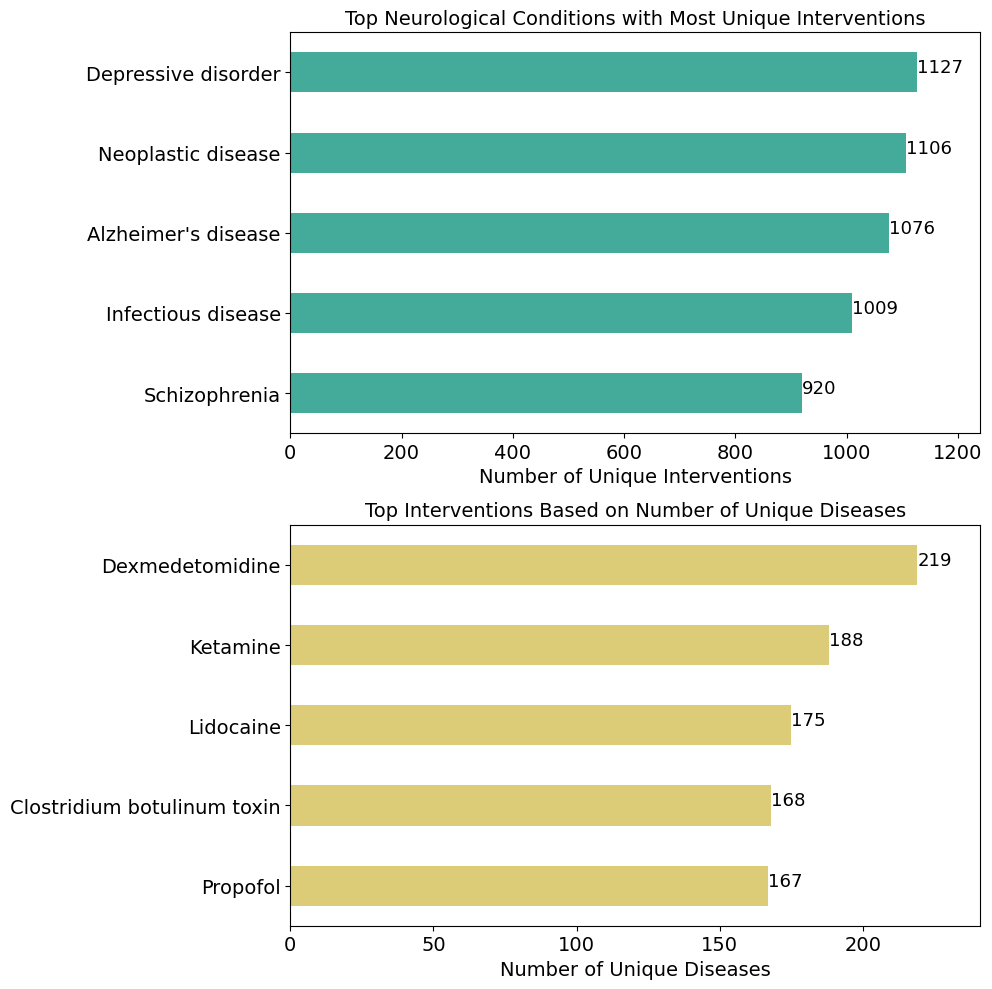

In [1896]:

# First plot: Top Neurological Condition with the most unique Interventions
top_conditions = filtered_df_unique.groupby('Neurological Condition')['Drug Intervention'].nunique().sort_values(ascending=False).head()

# Second plot: Top Intervention based on the number of unique diseases it has been used for
top_interventions = filtered_df_unique.groupby('Drug Intervention')['Neurological Condition'].nunique().sort_values(ascending=False).head()

# Plotting both charts in a single figure
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Plot for top Neurological Condition with most unique Interventions
top_conditions.sort_values(ascending=True).plot(kind='barh', color='#44AA99', ax=axes[0])
axes[0].set_title('Top Neurological Conditions with Most Unique Interventions', fontsize=14)
axes[0].set_xlabel('Number of Unique Interventions', fontsize=14)
axes[0].set_ylabel('')
axes[0].tick_params(axis='y', labelsize=14)
axes[0].tick_params(axis='x', labelsize=14)

# Adding labels to the bars
for index, value in enumerate(top_conditions.sort_values(ascending=True)):
    axes[0].text(value, index, str(value),fontsize=13)

# Setting x-axis limit for the first plot
axes[0].set_xlim(0, max(top_conditions) + max(top_conditions) / 10)


# Plot for top Intervention based on the number of unique diseases
top_interventions.sort_values(ascending=True).plot(kind='barh', color='#DDCC77', ax=axes[1])
axes[1].set_title('Top Interventions Based on Number of Unique Diseases', fontsize=14)
axes[1].set_xlabel('Number of Unique Diseases', fontsize=14)
axes[1].set_ylabel('')

axes[1].tick_params(axis='y', labelsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].set_xlim(0, max(top_interventions) + max(top_interventions) / 10)

# Adding labels to the bars
for index, value in enumerate(top_interventions.sort_values(ascending=True)):
    axes[1].text(value, index, str(value), fontsize=13)
    

plt.tight_layout()

plt.savefig(f'viz/disease_intervention_frequency_{annotations_type}.pdf')

plt.show()


### interventions associated with most diseases

In [1647]:
# Step 1: Drop duplicates based on 'nct_id' and 'intervention_name'
unique_interventions_df = filtered_df[['nct_id', drug_col_name, condition_col_name]].drop_duplicates()

# Step 2: Identify the top 10 interventions
top_10_interventions = unique_interventions_df[drug_col_name].value_counts().head(10).index

print(top_10_interventions)

# Step 3: Create the dictionary for top 10 interventions with unique diseases
intervention_diseases_dict = {}
for intervention in top_10_interventions:
    # Get the unique diseases tested for each intervention
    #unique_diseases = set(unique_interventions_df[unique_interventions_df['intervention_name'] == intervention]['Neurological Disease'])
    # Get the unique diseases tested for each intervention that contain "(disorder)" in the name
    unique_diseases = {
        disease for disease in unique_interventions_df[unique_interventions_df[drug_col_name] == intervention][condition_col_name]
        if isinstance(disease, str) and "(disorder)" in disease 
    }
    intervention_diseases_dict[intervention] = unique_diseases



Index(['Risperidone (substance)', 'Anti-psychotic agent (substance)',
       'Dexmedetomidine (substance)', 'Ketamine (substance)',
       'Olanzapine (substance)', 'Levodopa (substance)',
       'Clostridium botulinum toxin (substance)', 'Quetiapine (substance)',
       'Botulinum toxin type A\n(substance)', 'Aripiprazole (substance)'],
      dtype='object', name='Drug Intervention')


In [1648]:
unique_interventions_df[drug_col_name].value_counts().head(10)

Drug Intervention
Risperidone (substance)                    901
Anti-psychotic agent (substance)           820
Dexmedetomidine (substance)                807
Ketamine (substance)                       789
Olanzapine (substance)                     676
Levodopa (substance)                       614
Clostridium botulinum toxin (substance)    583
Quetiapine (substance)                     580
Botulinum toxin type A\n(substance)        570
Aripiprazole (substance)                   555
Name: count, dtype: int64

In [1649]:
intervention_diseases_dict['Ketamine (substance)']

{'Acquired cardiac septal defect\n(disorder)',
 'Acute abdomen (disorder)',
 'Acute disease (disorder)',
 'Acute inflammatory disease (disorder)',
 'Adjustment disorder (disorder)',
 'Aneurysm (disorder)',
 'Anxiety disorder (disorder)',
 'Behavioral syndrome associated with\nphysiological disturbance and physical\nfactors (disorder)',
 'Benign intracranial hypertension (disorder)',
 'Bipolar disorder (disorder)',
 'Blood coagulation disorder (disorder)',
 'Bodily distress disorder (disorder)',
 'Bone inflammatory disease (disorder)',
 'Burn (disorder)',
 'Cancer treatment related morbidity\n(disorder)',
 'Cardiac arrest (disorder)',
 'Cardiac complication of procedure\n(disorder)',
 'Celiac disease (disorder)',
 'Central pain syndrome (disorder)',
 'Cerebrovascular accident (disorder)',
 'Childhood and adolescent fearfulness\ndisturbance (disorder)',
 'Childhood or adolescent disorder\nof social functioning (disorder)',
 'Chronic disease (disorder)',
 'Chronic mental disorder (disorde

10


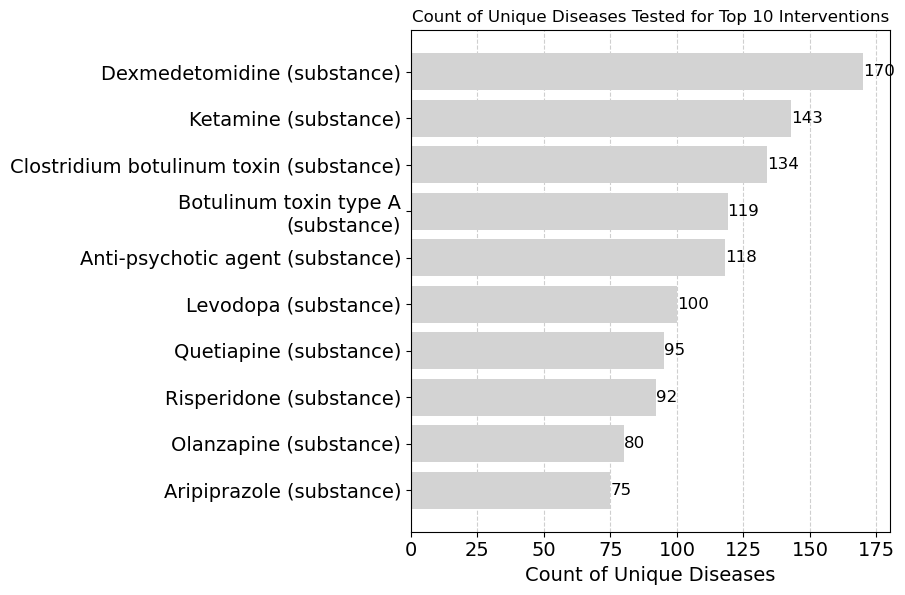

In [1650]:
# Calculate unique diseases count for each intervention
unique_diseases_counts = [len(diseases) for diseases in intervention_diseases_dict.values()]
# Extract the interventions list for ordering
interventions = list(intervention_diseases_dict.keys())
print(len(interventions))

# Sort interventions by the count of unique diseases in descending order
sorted_indices = sorted(range(len(unique_diseases_counts)), key=lambda i: unique_diseases_counts[i], reverse=False)
sorted_interventions = [interventions[i] for i in sorted_indices]
sorted_unique_diseases_counts = [unique_diseases_counts[i] for i in sorted_indices]

# Plotting with sorted data
plt.figure(figsize=(8, 6))
bars = plt.barh(sorted_interventions, sorted_unique_diseases_counts, color='lightgrey', zorder=2)

# Add labels to each bar
for bar, count in zip(bars, sorted_unique_diseases_counts):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{count}', va='center', fontsize=12)

plt.xlabel('Count of Unique Diseases', fontsize=14)
#plt.ylabel('Intervention')
plt.title('Count of Unique Diseases Tested for Top 10 Interventions')
plt.tight_layout()
plt.xlim(0, max(sorted_unique_diseases_counts) + 10)  # Adjusted to max count for relevancy
plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)
# Include grid lines on the x-axis
plt.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)

plt.show()


In [1662]:
sorted_interventions[-5:]


['Anti-psychotic agent (substance)',
 'Botulinum toxin type A\n(substance)',
 'Clostridium botulinum toxin (substance)',
 'Ketamine (substance)',
 'Dexmedetomidine (substance)']

In [1651]:
interventions = list(intervention_diseases_dict.keys())
interventions

['Risperidone (substance)',
 'Anti-psychotic agent (substance)',
 'Dexmedetomidine (substance)',
 'Ketamine (substance)',
 'Olanzapine (substance)',
 'Levodopa (substance)',
 'Clostridium botulinum toxin (substance)',
 'Quetiapine (substance)',
 'Botulinum toxin type A\n(substance)',
 'Aripiprazole (substance)']

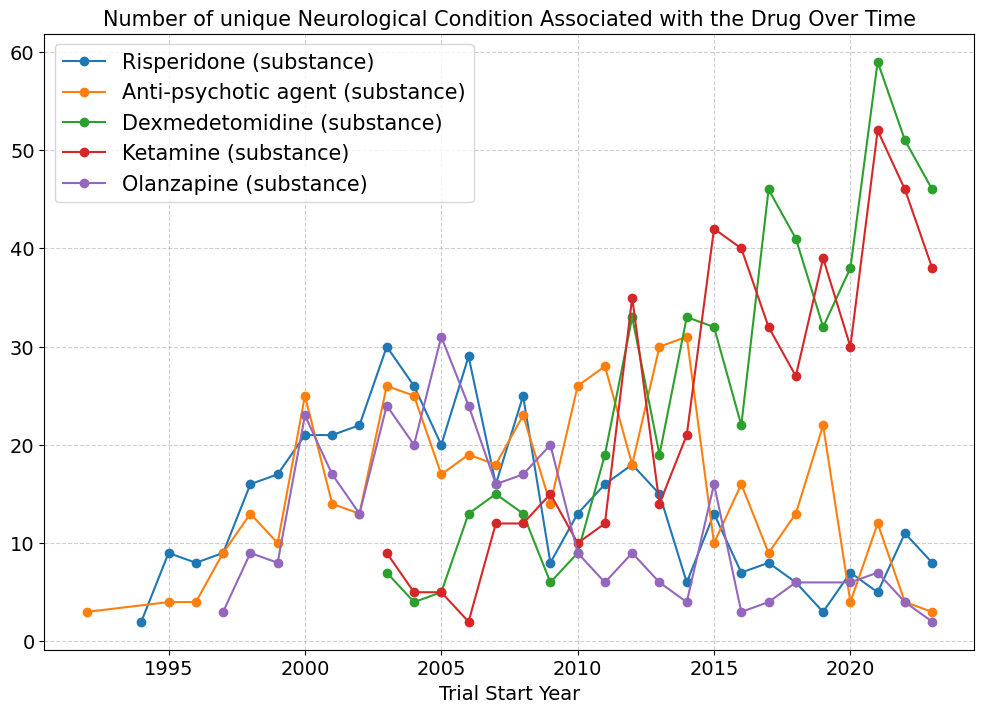

In [1664]:
# Function to get the unique diseases started in each year for given interventions
def get_unique_diseases_by_year(df, intervention):
    filtered_df = df[df[drug_col_name] == intervention]
    result = filtered_df.groupby('start_year')[condition_col_name].nunique().reset_index()
    result.columns = ['start_year', 'unique_disease_count']
    return result

# Function to plot the result
def plot_unique_diseases_over_time(df, interventions):
    plt.figure(figsize=(12, 8))
    for intervention in interventions:
        result_df = get_unique_diseases_by_year(df, intervention)
        plt.plot(result_df['start_year'], result_df['unique_disease_count'], marker='o', linestyle='-', label=intervention)
    plt.title('Number of unique Neurological Condition Associated with the Drug Over Time', fontsize=15)
    plt.xlabel('Trial Start Year', fontsize=14)
    #plt.ylabel('Unique Neurological Disease Count')
    plt.legend(fontsize=15, loc='upper left')
        # Adjusting the tick size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
  
    plt.grid(linestyle='--', alpha=0.6, zorder=1)
    plt.savefig(f'viz/disease_per_intervention_frequency_{annotations_type}.pdf')

    plt.show()

# Example usage
selected_interventions = ['Ketamine (substance)', 'Levodopa (substance)']

plot_unique_diseases_over_time(filtered_df,interventions[:5])# sorted_interventions[-5:])
#interventions[:5])


# Comparison aact vs bert

In [93]:
df = pd.read_excel("data/quality_checks/biolinkbert_annotations_sample2_50_reviewed.xlsx")

In [94]:
df.head()

,nct_id,canonical_aact_interventions,canonical_BioLinkBERT-base_interventions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,"bert_performance (0: equal, 1: better, 2: worse)",tricky,comment
0,NCT01942161,aripiprazole high (24 - 30 mg/day)|aripiprazol...,aripiprazole,schizophrenia,schizophrenia,1,NaN,NaN
1,NCT02363517,sofosbuvir/ledispasvir fixed dose combination ...,ledipasvir|sofosbuvir,"substance abuse, intravenous|hepatitis c",hepatitis c virus,2,1.0,substance abuse indirectly implied
2,NCT03945279,biib100,biib100,amyotrophic lateral sclerosis,amyotrophic lateral sclerosis,0,NaN,NaN
3,NCT01137110,NaN,levetiracetam,subarachnoid hemorrhage,seizures|subarachnoid hemorrhage,1,NaN,NaN
4,NCT00004418,glyceryl trierucate/glyceryl trioleate,glyceryl trierucate|glyceryl trioleate|lorenzo...,adrenoleukodystrophy,adrenoleukodystrophy,1,NaN,NaN


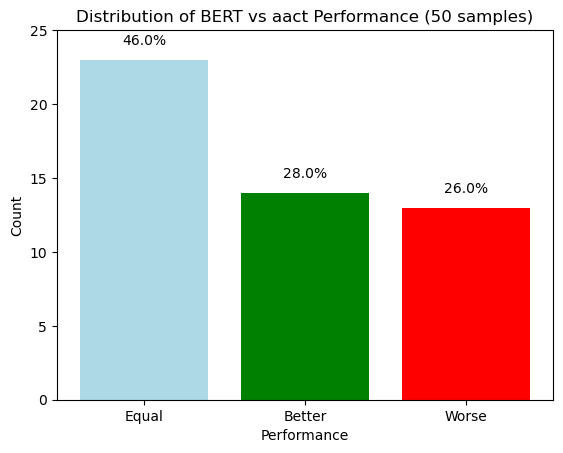

In [98]:
# Group by 'bert_performance' and count occurrences
performance_distribution = df['bert_performance (0: equal, 1: better, 2: worse)'].value_counts()

# Define labels for each category
labels = ['Equal', 'Better', 'Worse']

# Plot the bar chart
plt.bar(labels, performance_distribution, color=['lightblue', 'green', 'red'])

# Calculate the percentage of each category
total_count = performance_distribution.sum()
percentages = [count / total_count * 100 for count in performance_distribution]

# Annotate bars with percentages
for i, percentage in enumerate(percentages):
    plt.text(i, performance_distribution[i] + 1, f"{percentage:.1f}%", ha='center')
    
# Set the y-axis limit to reach 30
plt.ylim(0, 25)
# Set the title and labels
plt.title('Distribution of BERT vs aact Performance (50 samples)')
plt.xlabel('Performance')
plt.ylabel('Count')

plt.savefig("viz/bert_vs_aact_manual.png")
# Show the plot
plt.show()

### BERT advantages
- more details
- more specific
- easier to aggregate

In [96]:
df[df['bert_performance (0: equal, 1: better, 2: worse)'] == 1]

,nct_id,canonical_aact_interventions,canonical_BioLinkBERT-base_interventions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,"bert_performance (0: equal, 1: better, 2: worse)",tricky,comment
0,NCT01942161,aripiprazole high (24 - 30 mg/day)|aripiprazol...,aripiprazole,schizophrenia,schizophrenia,1,NaN,NaN
3,NCT01137110,NaN,levetiracetam,subarachnoid hemorrhage,seizures|subarachnoid hemorrhage,1,NaN,NaN
4,NCT00004418,glyceryl trierucate/glyceryl trioleate,glyceryl trierucate|glyceryl trioleate|lorenzo...,adrenoleukodystrophy,adrenoleukodystrophy,1,NaN,NaN
5,NCT00829218,type: other,glutamate|msg,fibromyalgia|irritable bowel syndrome,fibromyalgia|ibs|irritable bowel syndrome,1,NaN,NaN
7,NCT00331825,risperidone and olanzapine,olanzapine|risperidone,extrapyramidal syndrome|schizophrenia,eps|neuroleptic-induced acute dystonia|parkins...,1,1.0,extrapyramidal syndrome not in the text
8,NCT03406702,cx-8998,cx-8998,epilepsy,absence seizures|idiopathic generalized epilepsy,1,1.0,only epilepsy missing in bert
10,NCT06100276,amt-162,amt-162|therapy,amyotrophic lateral sclerosis,rapidly progressive als|sod1 amyotrophic later...,1,1.0,abbreviations not well disambiguated
11,NCT00095524,aripiprazole,aripiprazole|olanzapine,schizoaffective disorder|psychotic disorders|b...,overweight|psychotic disorders|schizoaffective...,1,NaN,NaN
16,NCT01957774,thr-18,alteplase|thr-18|tissue plasminogen activator,stroke,acute ischemic stroke|ischemic strokes|stroke,1,NaN,NaN
27,NCT01883505,levodopa and carbidopa,carbidopa|ld|levodopa|nd0612,parkinson disease,- treated|motor fluctuations|parkinson disease,1,NaN,NaN


### Issues
- main issue: mentions available in other parts of the data, e.g. brief title, detailed trial description
- extractions noise

In [97]:
df[df['bert_performance (0: equal, 1: better, 2: worse)'] == 2]

,nct_id,canonical_aact_interventions,canonical_BioLinkBERT-base_interventions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,"bert_performance (0: equal, 1: better, 2: worse)",tricky,comment
1,NCT02363517,sofosbuvir/ledispasvir fixed dose combination ...,ledipasvir|sofosbuvir,"substance abuse, intravenous|hepatitis c",hepatitis c virus,2,1.0,substance abuse indirectly implied
9,NCT00538642,ziprasidone,antipsychotics|ziprasidone,schizoaffective disorder|psychotic disorders|b...,bipolar disorder|diabetes|diabetic|pre-diabeti...,2,1.0,NaN
14,NCT03432871,type: dietary supplement,nicotinamide riboside,progressive external ophthalmoplegia|ophthalmo...,mitochondrial disease|mitochondrial disorders,2,1.0,ophthalmoplegia mentioned only in the detailed...
19,NCT00986115,memantine,memantine,epilepsy,alzheimer disease|epilepsy|seizures,2,1.0,alzheimer disease is a false positive
22,NCT01280006,celecoxib|indomethacin,NaN,stroke|hypertension|cardiovascular diseases|sl...,intermittent hypoxia,2,1.0,Arms and Interventions field of AACT? Missing ...
23,NCT02034474,tocilizumab,il-6 receptor antibody|tocilizumab,schizoaffective disorder|psychotic disorders|s...,"residual positive, negative, and cognitive sym...",2,NaN,NaN
25,NCT01069159,propranolol hydrochloride,propranolol,"stress disorders, post-traumatic|traumatic memory",propranolol treatment of traumatic memories|tr...,2,NaN,NaN
28,NCT00320723,"bupropion, transdermal nicotine patch",bupropion,schizoaffective disorder|psychotic disorders|s...,major mental illness|smoking,2,1.0,schizophrenia mentioned in brief title and det...
34,NCT00242177,actos (pioglitazone),NaN,"multiple sclerosis, relapsing-remitting","multiple sclerosis|multiple sclerosis, relapsi...",2,1.0,drug was mentioned in the detailed description
35,NCT01453127,i-123 ioflupane solution injection prior to sp...,NaN,rem sleep behavior disorder|dementia|parkinson...,alzheimer disease|dementia with lewy bodies|mi...,2,1.0,drug was mentioned in the detailed description


## disease-intervention pairs

In [99]:
if evaluate_snomed_link:
    suffix = "_sapbert"
else:
    suffix = ""

In [101]:
pairs_aact = pd.read_csv(f"./analysis/disease_intervenion_pairs_aact{suffix}.csv", index_col=0)
pairs_aact['disease_intervention_pair'] = pairs_aact['disease_intervention_pair'].str.lower()

pairs_bert = pd.read_csv(f"./analysis/disease_intervenion_pairs_biolinkbert{suffix}.csv", index_col=0)
pairs_bert['disease_intervention_pair'] = pairs_bert['disease_intervention_pair'].str.lower()


In [102]:
grouped_df_aact = pairs_aact.groupby('disease_intervention_pair').agg(
    nct_ids_aact=('nct_id', list),              # Create a list of nct_ids
    count_nct_ids_aact=('nct_id', 'nunique')    # Count unique nct_ids
).reset_index()
grouped_df_aact = grouped_df_aact.sort_values(by='count_nct_ids_aact', ascending=False)
grouped_df_aact

,disease_intervention_pair,nct_ids_aact,count_nct_ids_aact
29111,schizophrenia - risperidone (substance),"[NCT00000374, NCT00006195, NCT00014001, NCT000...",170
28919,schizophrenia - olanzapine (substance),"[NCT00000374, NCT00001656, NCT00006195, NCT000...",128
28545,schizophrenia - aripiprazole (substance),"[NCT00036127, NCT00036361, NCT00044655, NCT000...",109
28943,schizophrenia - paliperidone palmitate,"[NCT00073320, NCT00077714, NCT00078039, NCT000...",83
7995,delirium - dexmedetomidine (substance),"[NCT00095251, NCT00351299, NCT00455143, NCT004...",82
...,...,...,...
12327,facioscapulohumeral muscular dystrophy (disord...,[NCT03123913],1
12326,facioscapulohumeral muscular dystrophy (disord...,[NCT00104078],1
12325,facioscapulohumeral muscular dystrophy (disord...,[NCT02948244],1
12324,facioscapulohumeral muscular dystrophy (disord...,[NCT01970735],1


In [103]:
grouped_df_bert = pairs_bert.groupby('disease_intervention_pair').agg(
    nct_ids_bert=('nct_id', list),              # Create a list of nct_ids
    count_nct_ids_bert=('nct_id', 'nunique')    # Count unique nct_ids
).reset_index()
grouped_df_bert = grouped_df_bert.sort_values(by='count_nct_ids_bert', ascending=False)


In [104]:
grouped_df_bert

,disease_intervention_pair,nct_ids_bert,count_nct_ids_bert
39041,schizophrenia - anti-psychotic agent (substance),"[NCT00000371, NCT00001656, NCT00005658, NCT000...",261
32716,parkinson's disease - levodopa (substance),"[NCT00004576, NCT00004733, NCT00006077, NCT000...",205
39435,schizophrenia - risperidone (substance),"[NCT00000267, NCT00006195, NCT00014001, NCT000...",176
39343,schizophrenia - olanzapine (substance),"[NCT00001656, NCT00006195, NCT00007774, NCT000...",134
41268,smoker - nicotine,"[NCT00108537, NCT00115687, NCT00135746, NCT001...",108
...,...,...,...
17360,frame-shift mutation - multiple of the median ...,[NCT00844597],1
17361,frame-shift mutation - naftifine hydrochloride,[NCT02500381],1
17362,frame-shift mutation - trvl 61866,[NCT00844597],1
17363,fraxinus americana specific diagnostic allerge...,[NCT00224640],1


In [105]:
# Merge the DataFrames on 'disease_intervention_pair'
merged_df = pd.merge(grouped_df_aact, grouped_df_bert, on='disease_intervention_pair', how='outer')

# Function to calculate intersections and differences
def calculate_overlaps(row):
    ids_a = set(row['nct_ids_aact']) if isinstance(row['nct_ids_aact'], list) else set()
    ids_b = set(row['nct_ids_bert']) if isinstance(row['nct_ids_bert'], list) else set()
    overlap = ids_a & ids_b
    unique_aact = ids_a - ids_b
    unique_bert = ids_b - ids_a
    return pd.Series({
        'overlap_count': len(overlap),
        'unique_aact_count': len(unique_aact),
        'unique_bert_count': len(unique_bert),
        'overlap_values': list(overlap),
        'unique_aact_values': list(unique_aact),
        'unique_bert_values': list(unique_bert)
    })

# Apply the function to each row
merged_df[['overlap_count', 'unique_aact_count', 'unique_bert_count', 
           'overlap_values', 'unique_aact_values', 'unique_bert_values']] = merged_df.apply(calculate_overlaps, axis=1)



In [106]:
merged_df.head(2)

,disease_intervention_pair,nct_ids_aact,count_nct_ids_aact,nct_ids_bert,count_nct_ids_bert,overlap_count,unique_aact_count,unique_bert_count,overlap_values,unique_aact_values,unique_bert_values
0,1011 - 1011,[NCT03829878],1.0,NaN,NaN,0,1,0,[],[NCT03829878],[]
1,115 - adult vaccine product containing only ac...,NaN,NaN,[NCT01642589],1.0,0,0,1,[],[],[NCT01642589]


In [107]:
merged_df['combined_frq'] = merged_df['overlap_count'] + merged_df['unique_aact_count'] + merged_df['unique_bert_count']
merged_df = merged_df.sort_values(by='combined_frq', ascending=False)


In [109]:
merged_df.head()

,disease_intervention_pair,nct_ids_aact,count_nct_ids_aact,nct_ids_bert,count_nct_ids_bert,overlap_count,unique_aact_count,unique_bert_count,overlap_values,unique_aact_values,unique_bert_values,combined_frq
60470,schizophrenia - anti-psychotic agent (substance),"[NCT00931996, NCT01050582, NCT01192880, NCT013...",10.0,"[NCT00000371, NCT00001656, NCT00005658, NCT000...",261.0,5,5,256,"[NCT03548155, NCT02983188, NCT02360319, NCT020...","[NCT05039489, NCT00931996, NCT01050582, NCT011...","[NCT00538642, NCT00169026, NCT00757705, NCT021...",266
61230,schizophrenia - risperidone (substance),"[NCT00000374, NCT00006195, NCT00014001, NCT000...",170.0,"[NCT00000267, NCT00006195, NCT00014001, NCT000...",176.0,95,75,81,"[NCT00526877, NCT00761670, NCT02019329, NCT001...","[NCT02051387, NCT00418873, NCT02650102, NCT021...","[NCT03237052, NCT00539071, NCT02765555, NCT008...",251
50703,parkinson's disease - levodopa (substance),"[NCT00004733, NCT00096720, NCT00153972, NCT004...",26.0,"[NCT00004576, NCT00004733, NCT00006077, NCT000...",205.0,18,8,187,"[NCT01351168, NCT00153972, NCT00004733, NCT015...","[NCT03119636, NCT01770145, NCT01283594, NCT062...","[NCT03582371, NCT00462007, NCT02225548, NCT005...",213
60989,schizophrenia - olanzapine (substance),"[NCT00000374, NCT00001656, NCT00006195, NCT000...",128.0,"[NCT00001656, NCT00006195, NCT00007774, NCT000...",134.0,77,51,57,"[NCT00485823, NCT00827918, NCT00169065, NCT002...","[NCT02051387, NCT02650102, NCT01129674, NCT001...","[NCT01420575, NCT02804568, NCT00078039, NCT000...",185
60483,schizophrenia - aripiprazole (substance),"[NCT00036127, NCT00036361, NCT00044655, NCT000...",109.0,"[NCT00036361, NCT00088049, NCT00095524, NCT001...",99.0,61,48,38,"[NCT00737256, NCT00352339, NCT00392197, NCT013...","[NCT02650102, NCT01104766, NCT02054702, NCT011...","[NCT00325689, NCT03237052, NCT01742390, NCT038...",147


In [110]:
# Sorting the DataFrame by 'combined_frq' and selecting the top 20
top_df = merged_df.sort_values(by='combined_frq', ascending=False).head(20)

# Calculate proportions scaled to 100
top_df['total'] = top_df['overlap_count'] + top_df['unique_aact_count'] + top_df['unique_bert_count']
top_df['overlap_pct'] = (top_df['overlap_count'] / top_df['total']) * 100
top_df['unique_aact_pct'] = (top_df['unique_aact_count'] / top_df['total']) * 100
top_df['unique_bert_pct'] = (top_df['unique_bert_count'] / top_df['total']) * 100
top_df.head()

,disease_intervention_pair,nct_ids_aact,count_nct_ids_aact,nct_ids_bert,count_nct_ids_bert,overlap_count,unique_aact_count,unique_bert_count,overlap_values,unique_aact_values,unique_bert_values,combined_frq,total,overlap_pct,unique_aact_pct,unique_bert_pct
60470,schizophrenia - anti-psychotic agent (substance),"[NCT00931996, NCT01050582, NCT01192880, NCT013...",10.0,"[NCT00000371, NCT00001656, NCT00005658, NCT000...",261.0,5,5,256,"[NCT03548155, NCT02983188, NCT02360319, NCT020...","[NCT05039489, NCT00931996, NCT01050582, NCT011...","[NCT00538642, NCT00169026, NCT00757705, NCT021...",266,266,1.879699,1.879699,96.240602
61230,schizophrenia - risperidone (substance),"[NCT00000374, NCT00006195, NCT00014001, NCT000...",170.0,"[NCT00000267, NCT00006195, NCT00014001, NCT000...",176.0,95,75,81,"[NCT00526877, NCT00761670, NCT02019329, NCT001...","[NCT02051387, NCT00418873, NCT02650102, NCT021...","[NCT03237052, NCT00539071, NCT02765555, NCT008...",251,251,37.848606,29.880478,32.270916
50703,parkinson's disease - levodopa (substance),"[NCT00004733, NCT00096720, NCT00153972, NCT004...",26.0,"[NCT00004576, NCT00004733, NCT00006077, NCT000...",205.0,18,8,187,"[NCT01351168, NCT00153972, NCT00004733, NCT015...","[NCT03119636, NCT01770145, NCT01283594, NCT062...","[NCT03582371, NCT00462007, NCT02225548, NCT005...",213,213,8.450704,3.755869,87.793427
60989,schizophrenia - olanzapine (substance),"[NCT00000374, NCT00001656, NCT00006195, NCT000...",128.0,"[NCT00001656, NCT00006195, NCT00007774, NCT000...",134.0,77,51,57,"[NCT00485823, NCT00827918, NCT00169065, NCT002...","[NCT02051387, NCT02650102, NCT01129674, NCT001...","[NCT01420575, NCT02804568, NCT00078039, NCT000...",185,185,41.621622,27.567568,30.810811
60483,schizophrenia - aripiprazole (substance),"[NCT00036127, NCT00036361, NCT00044655, NCT000...",109.0,"[NCT00036361, NCT00088049, NCT00095524, NCT001...",99.0,61,48,38,"[NCT00737256, NCT00352339, NCT00392197, NCT013...","[NCT02650102, NCT01104766, NCT02054702, NCT011...","[NCT00325689, NCT03237052, NCT01742390, NCT038...",147,147,41.496599,32.653061,25.850340


In [111]:
top_df.to_csv(f"analysis/overlapping_unique_nct_ids{suffix}.csv")

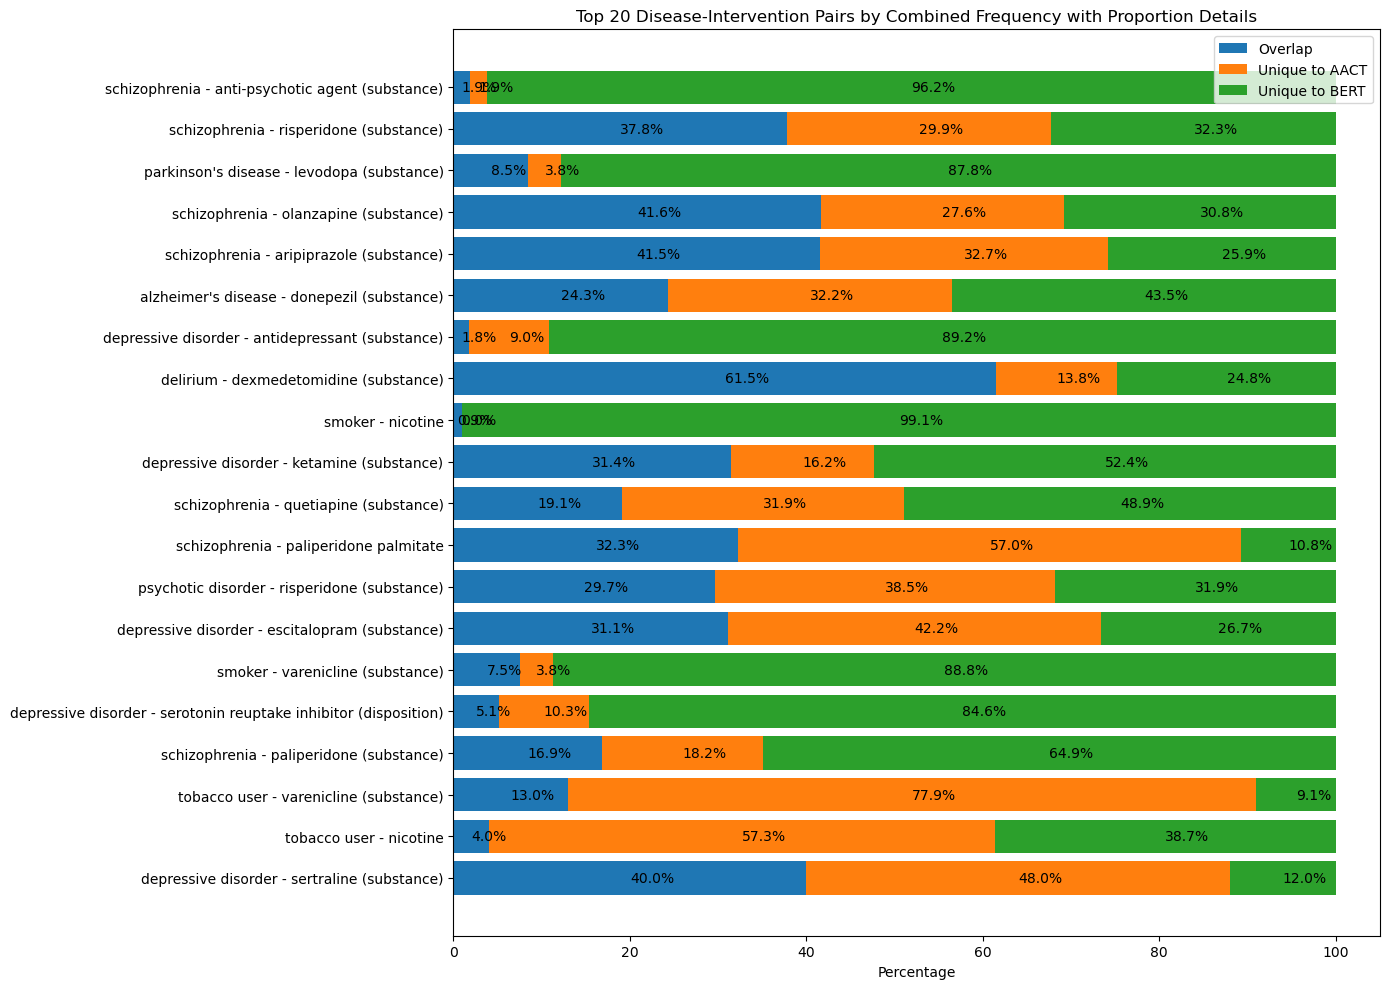

In [112]:
# Plotting
fig, ax = plt.subplots(figsize=(14, 10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Define color scheme
bars_overlap = ax.barh(top_df['disease_intervention_pair'], top_df['overlap_pct'], color=colors[0], label='Overlap')
bars_unique_aact = ax.barh(top_df['disease_intervention_pair'], top_df['unique_aact_pct'], left=top_df['overlap_pct'], color=colors[1], label='Unique to AACT')
bars_unique_bert = ax.barh(top_df['disease_intervention_pair'], top_df['unique_bert_pct'], left=top_df['overlap_pct'] + top_df['unique_aact_pct'], color=colors[2], label='Unique to BERT')

# Add labels to the bars
def add_labels(bars):
    for bar in bars:
        width = bar.get_width()
        label_x_pos = bar.get_x() + width / 2
        ax.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'{width:.1f}%', va='center')

add_labels(bars_overlap)
add_labels(bars_unique_aact)
add_labels(bars_unique_bert)

# Invert y-axis to have the first item at the top
ax.invert_yaxis()

ax.set_xlabel('Percentage')
ax.set_title('Top 20 Disease-Intervention Pairs by Combined Frequency with Proportion Details')
ax.set_yticks(range(len(top_df)))
ax.set_yticklabels(top_df['disease_intervention_pair'])
ax.legend()
plt.tight_layout()
plt.savefig(f'viz/bert_vs_aacts_drug_disease_pairs_nctids{suffix}.png')

plt.show()